# Notebook 24: Size Distribution on Full Sample

This notebook performs a segmentation workflow, adapted from NB 11,
on the F50 sand sample F63. The size distribution is determined by
combining the binning methods developed in NBs 22 (sphere of equivalent volume)
and 23 (aspect ratio), but this time on the full sample instead of a cropped
cube.

# Import packages

In [1]:
# Standard library imports
from pathlib import Path
# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy import signal
from skimage import color, measure
# Local module imports
from segmentflow import segment, view
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

## Error Summary

In [6]:
sieve_path = Path('../data/F63-slices_280_to_670-particle-sizes.csv')
sieve_df = pd.read_csv(sieve_path, index_col=0)
for i in np.arange(4, 9):
    print('min_peak_distance =', i)
    sieve_df[f'seg-{i}-sphere-error'] = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'seg-{i}-sphere-pct'])
    sphere_error = round(sieve_df[f'seg-{i}-sphere-error'].sum(), 2)
    print('Equiv sphere error:', sphere_error)
    sieve_df[f'seg-{i}-aspect-error'] = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'seg-{i}-aspect-pct'])
    aspect_error = round(sieve_df[f'seg-{i}-aspect-error'].sum(), 2)
    print('Aspect ratio error:', aspect_error)
    print('Total error:', sphere_error + aspect_error)
    print()
# sieve_df.to_csv(sieve_path)

min_peak_distance = 4
Equiv sphere error: 79.29
Aspect ratio error: 63.09
Total error: 142.38

min_peak_distance = 5
Equiv sphere error: 47.95
Aspect ratio error: 45.31
Total error: 93.26

min_peak_distance = 6
Equiv sphere error: 25.08
Aspect ratio error: 52.97
Total error: 78.05

min_peak_distance = 7
Equiv sphere error: 30.9
Aspect ratio error: 74.84
Total error: 105.74000000000001

min_peak_distance = 8
Equiv sphere error: 55.54
Aspect ratio error: 98.59
Total error: 154.13



## Load 3D data

Portion of the dataset described by `slice_crop` includes the first and last
slice that is complete due to slight tilt of sample compared to axis 0

Loading images...
--> Images loaded as 3D array:  (390, 1024, 1004)
Plotting images: [100, 200, 300]


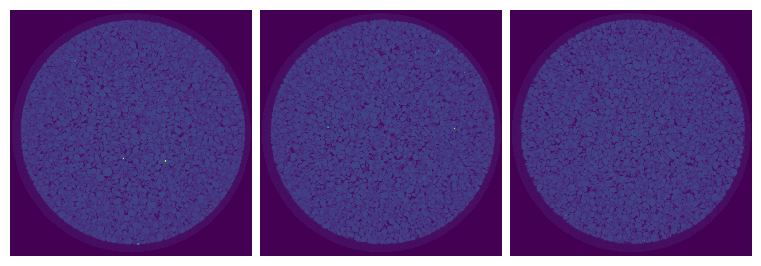

In [6]:
ums_per_pixel = 13.84
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
    Path('../data/F63tiff/'),
    slice_crop=[280, 670],
    row_crop=None,
    col_crop=None,
    convert_to_float=True,
    file_suffix='tiff'
)
slices = [100, 200, 300]
fig, axes = view.plot_slices(imgs, slices=slices)

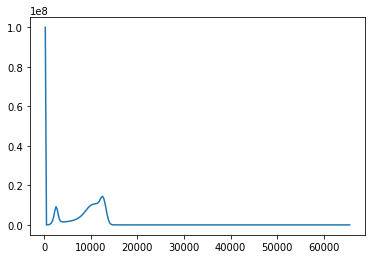

In [7]:
hist, bin_edges = np.histogram(imgs, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

## Preprocess data

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0, 99.9]...
--> Preprocessing complete
Plotting images: [100, 200, 300]


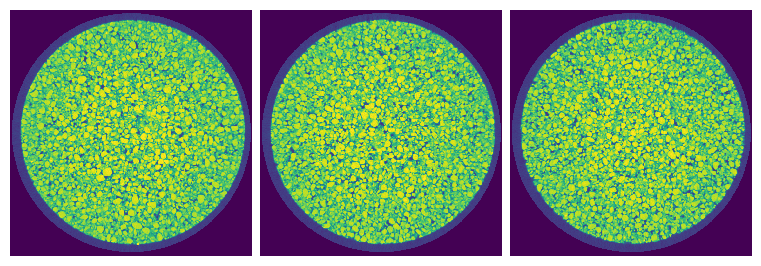

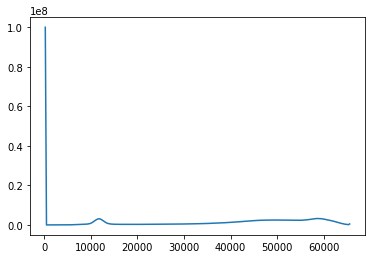

In [8]:
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[0, 99.9]
)
fig, axes = view.plot_slices(imgs_pre, slices=slices)
hist, bin_edges = np.histogram(imgs_pre, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

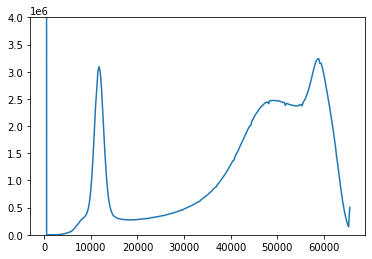

In [9]:
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
ax.set_ylim([0, 4e6])
plt.show()

--> 3 peak(s) found: [11796.300000000001, 50461.950000000004, 58326.15]
--> 2 min(s) found: [19660.5, 52428.0]


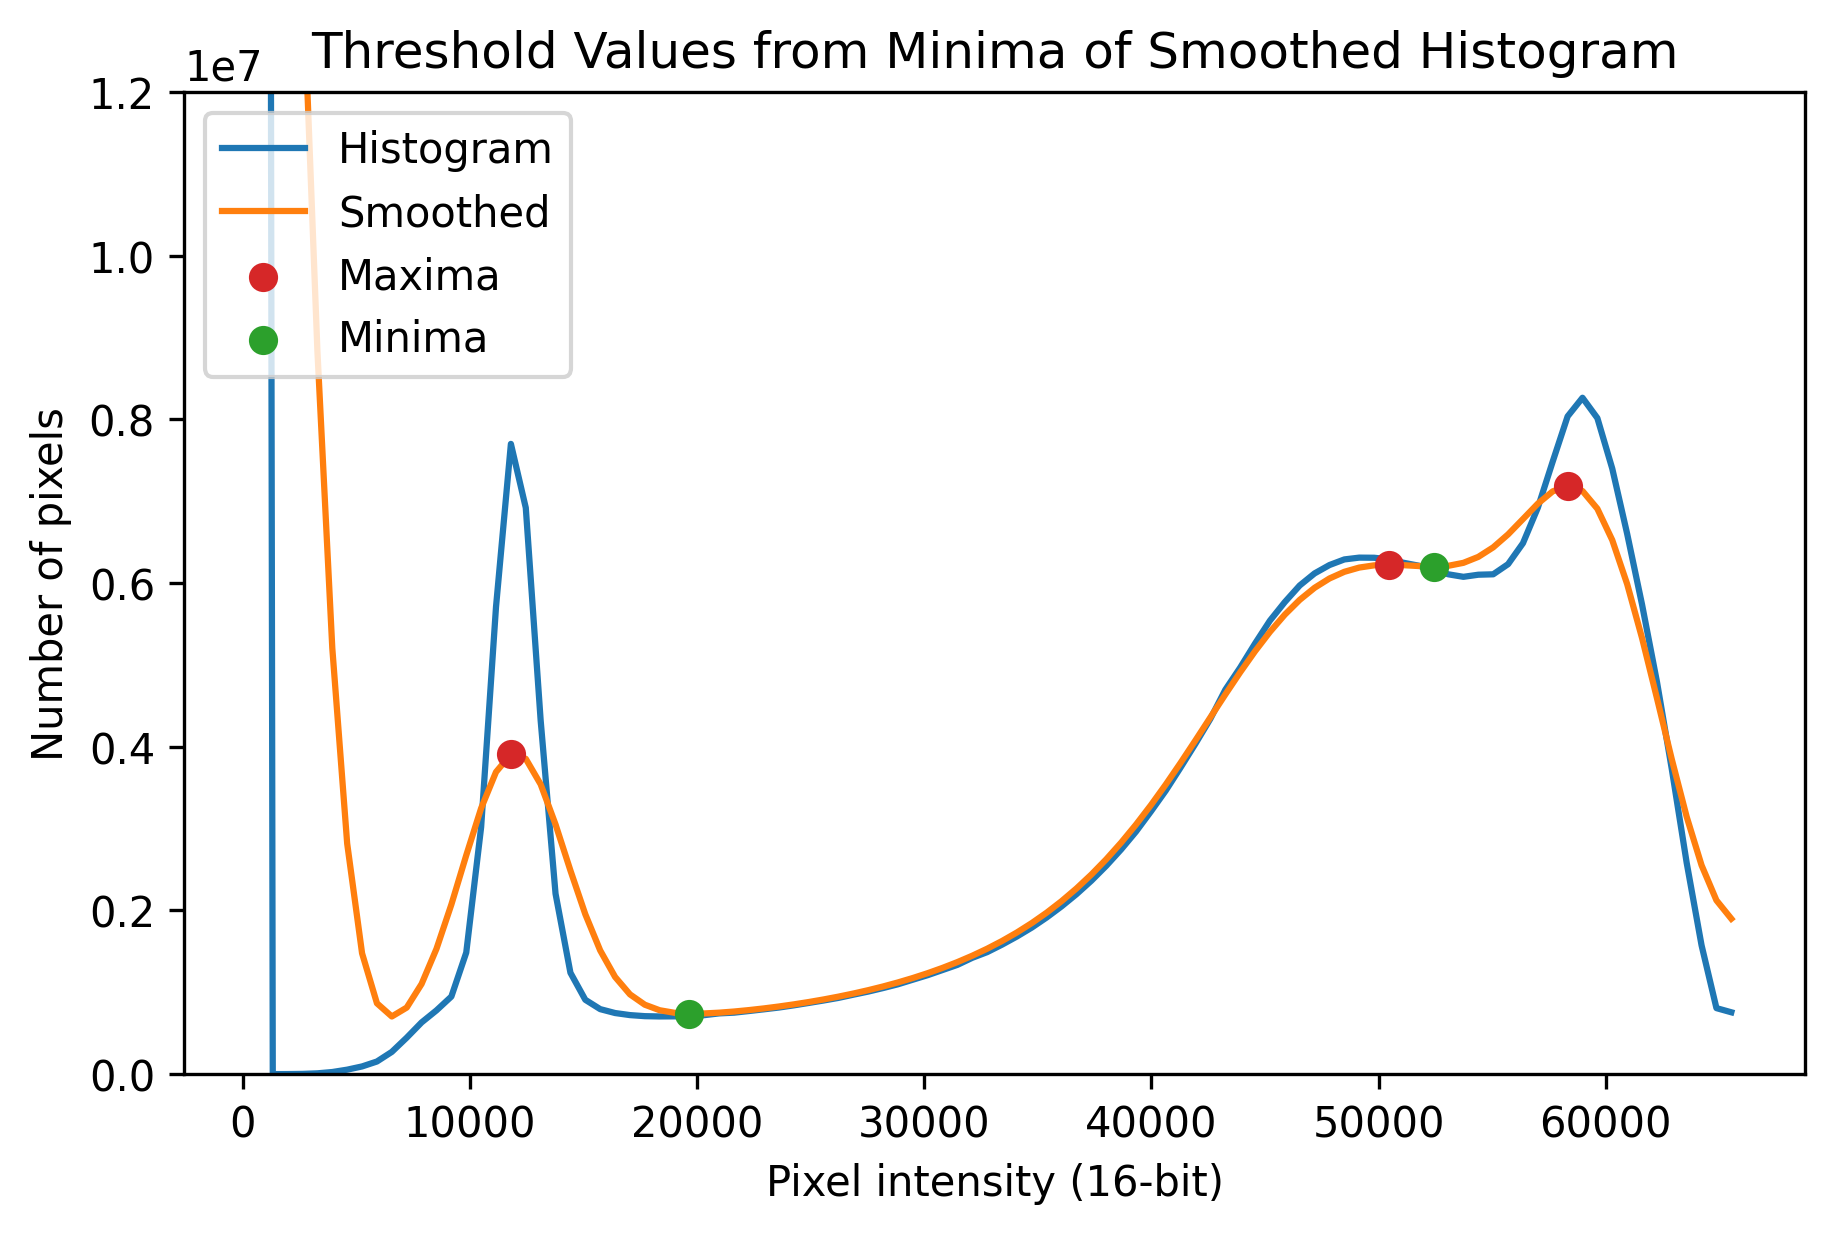

In [71]:
fig, ax = plt.subplots(constrained_layout=True, facecolor='white', dpi=300)
nbins = 100
# Calculate histogram
hist, bins = np.histogram(imgs_pre, bins=nbins)
ax.plot(bins[1:], hist, label='Histogram')
# Smooth histogram with Gaussian filter
hist_smooth = ndi.gaussian_filter(hist, 3)
ax.plot(bins[1:], hist_smooth, c='C1', label='Smoothed')
# Find local maxima in smoothed histogram
peak_inds, peak_props = signal.find_peaks(hist_smooth)
peaks = [bins[1 + i] for i in peak_inds]
print(f'--> {len(peaks)} peak(s) found: {peaks}')
ax.scatter(
    peaks, [hist_smooth[i] for i in peak_inds],
    color='C3', zorder=2, label='Maxima')
# Find minima between each neighboring pair of local maxima
min_inds = []
for i in range(1, len(peak_inds)):
    min_sub_i = np.argmin(hist_smooth[peak_inds[i - 1] : peak_inds[i]])
    min_inds.append(min_sub_i + peak_inds[i - 1])
mins = [bins[1 + i] for i in min_inds]
print(f'--> {len(mins)} min(s) found: {mins}')
ax.scatter(
    mins, [hist_smooth[i] for i in min_inds],
    color='C2', zorder=2, label='Minima')
ax.set_title('Threshold Values from Minima of Smoothed Histogram')
ax.set_ylim([0, 1.2e7])
ax.set_ylabel('Number of pixels')
ax.set_xlabel('Pixel intensity (16-bit)')
ax.legend(loc='upper left')
plt.show()

n_vox_binder=143702450
n_vox_grains=115977366
n_vox_nonvoid=259679816
Plotting images: [100, 200, 300]


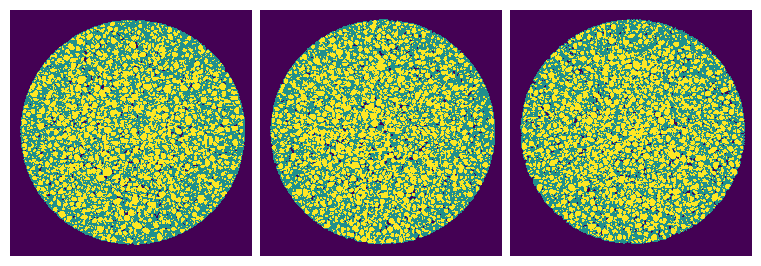

In [11]:
imgs_semantic = segment.isolate_classes(imgs_pre, mins)
n_vox_binder = (imgs_semantic == 1).sum()
print(f'{n_vox_binder=}')
n_vox_grains = (imgs_semantic == 2).sum()
print(f'{n_vox_grains=}')
n_vox_nonvoid = (imgs_semantic > 0).sum()
print(f'{n_vox_nonvoid=}')
fig, axes = view.plot_slices(imgs_semantic, slices=slices)

## Segment Data

### Single segmentation

Segmenting images...
--> Segmentation complete. 32642 particle(s) segmented.


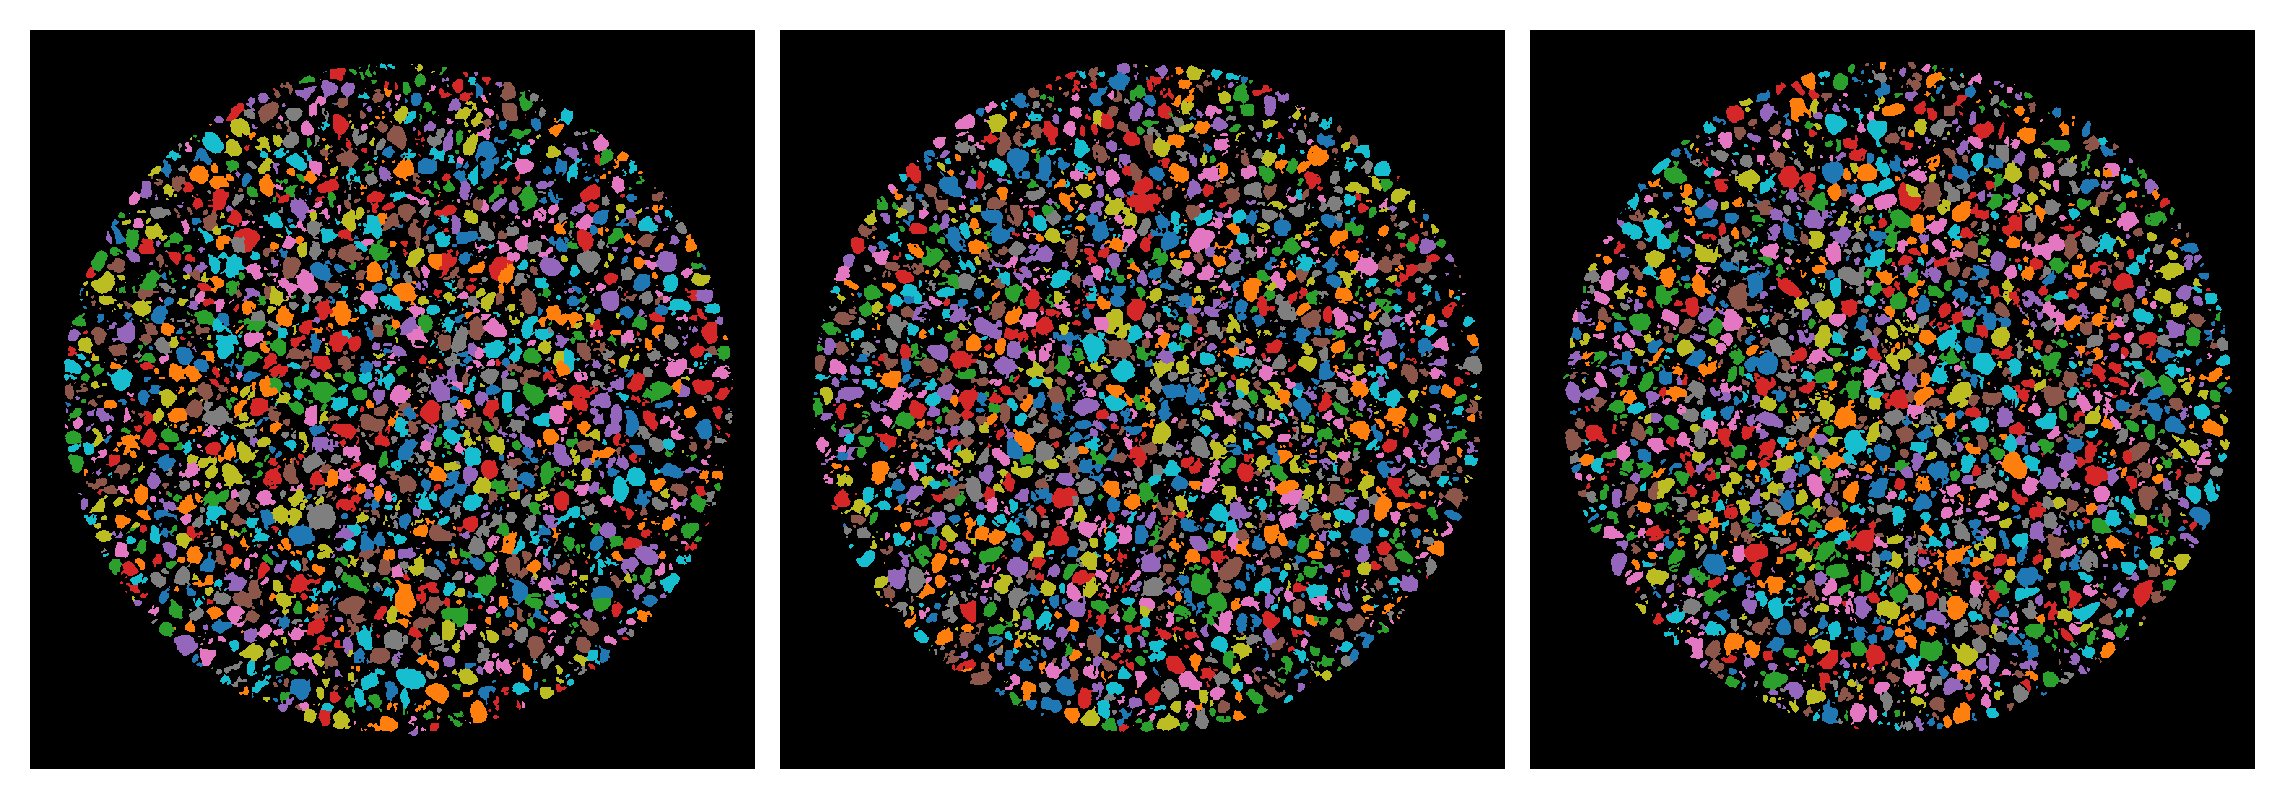

In [12]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=7,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images(labeled_color, dpi=300)

### Compare effect of `min_peak_distance` on size

min_peak_distance = 8
Segmenting images...
--> Segmentation complete. 26432 particle(s) segmented.


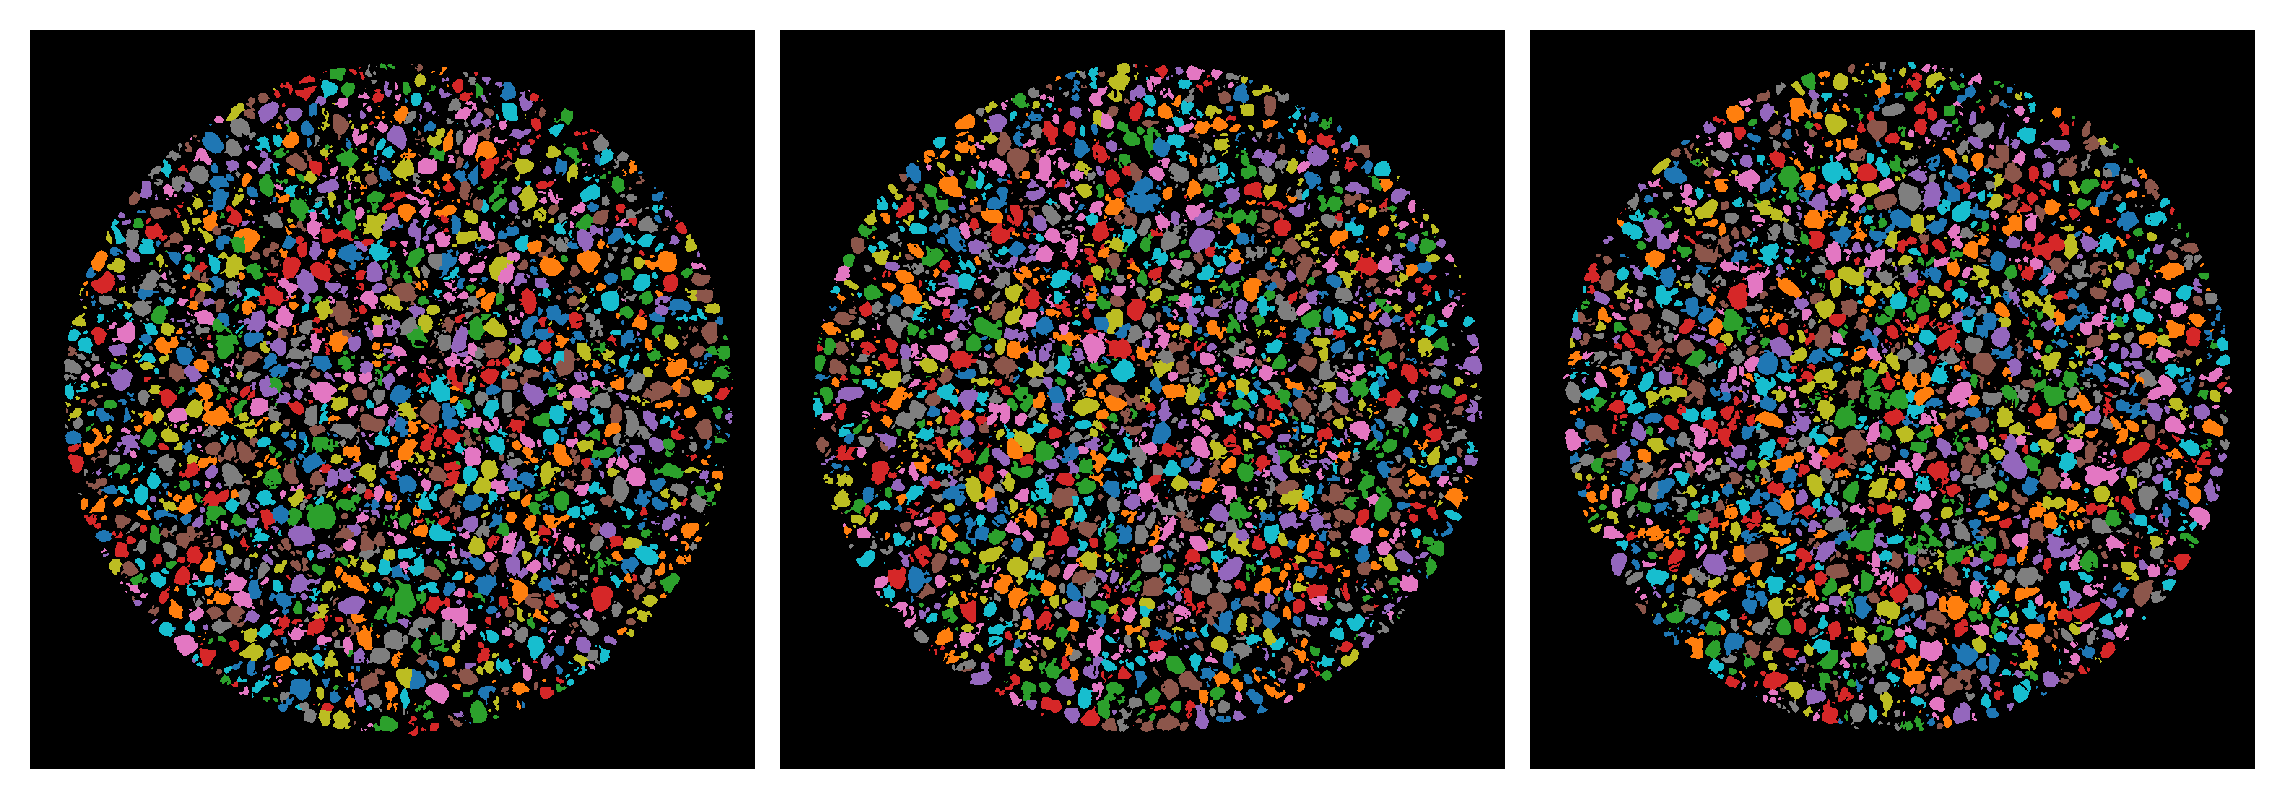

min_peak_distance = 7
Segmenting images...
--> Segmentation complete. 32642 particle(s) segmented.


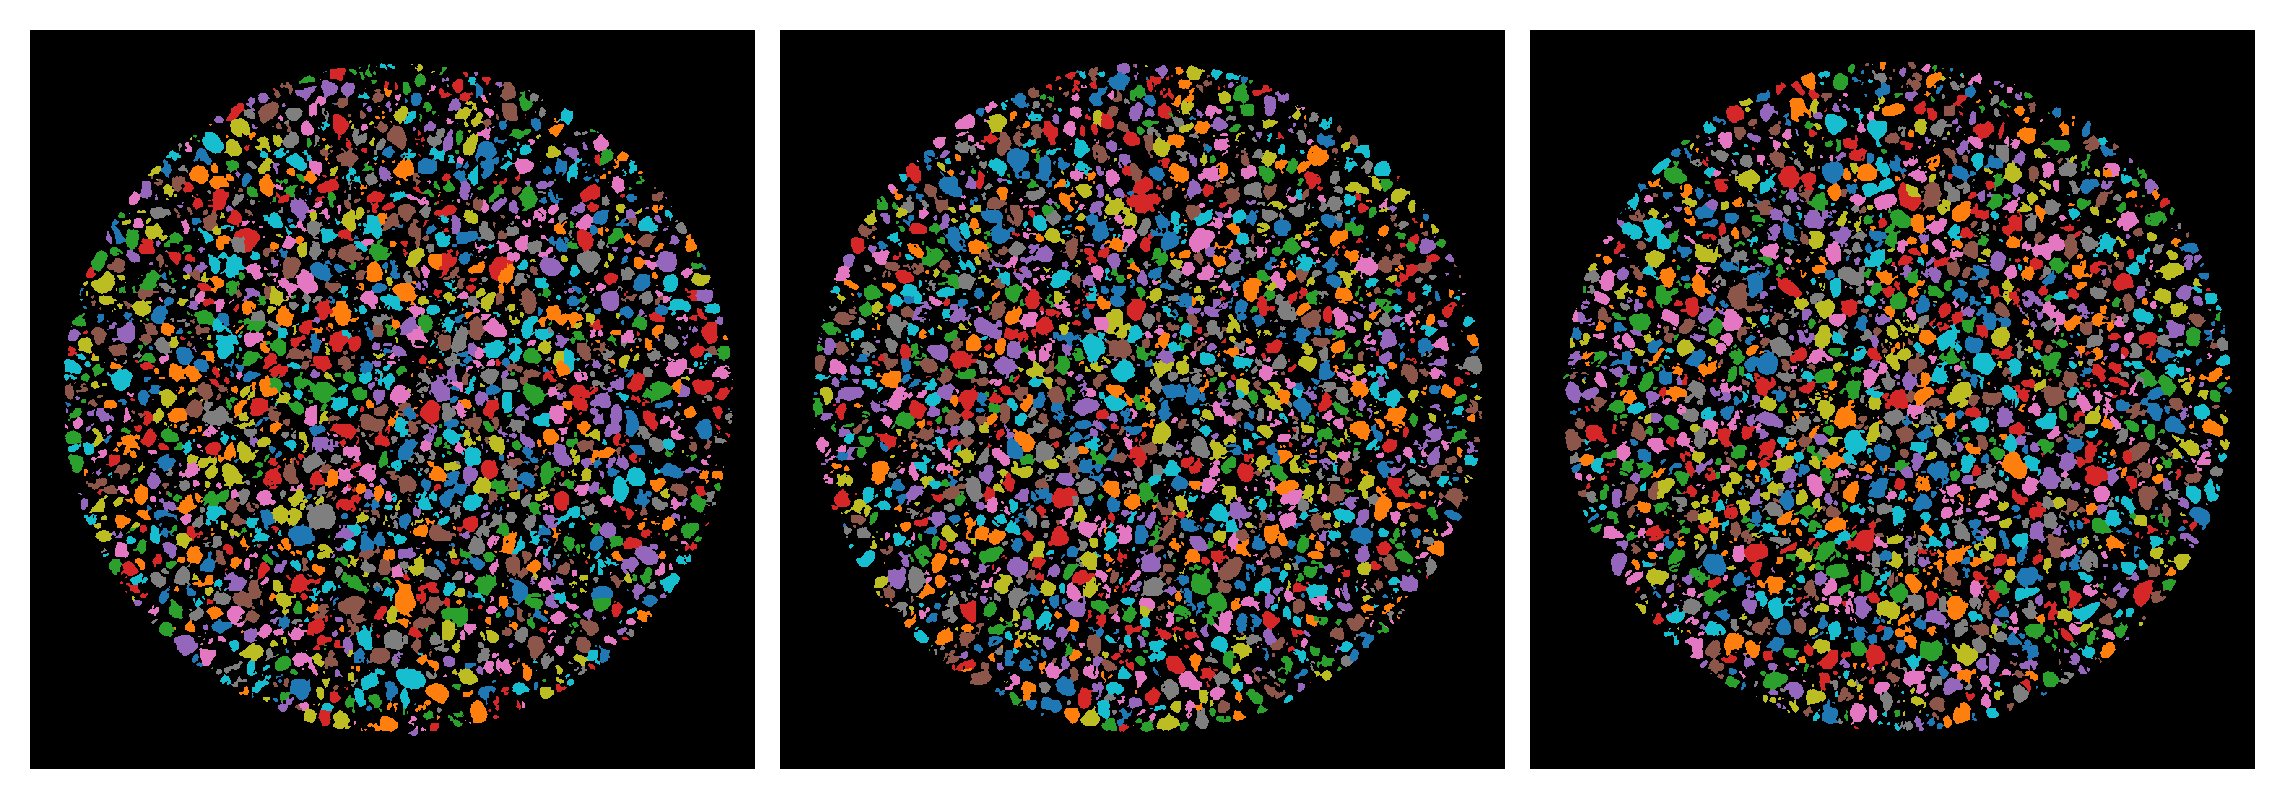

min_peak_distance = 6
Segmenting images...
--> Segmentation complete. 41641 particle(s) segmented.


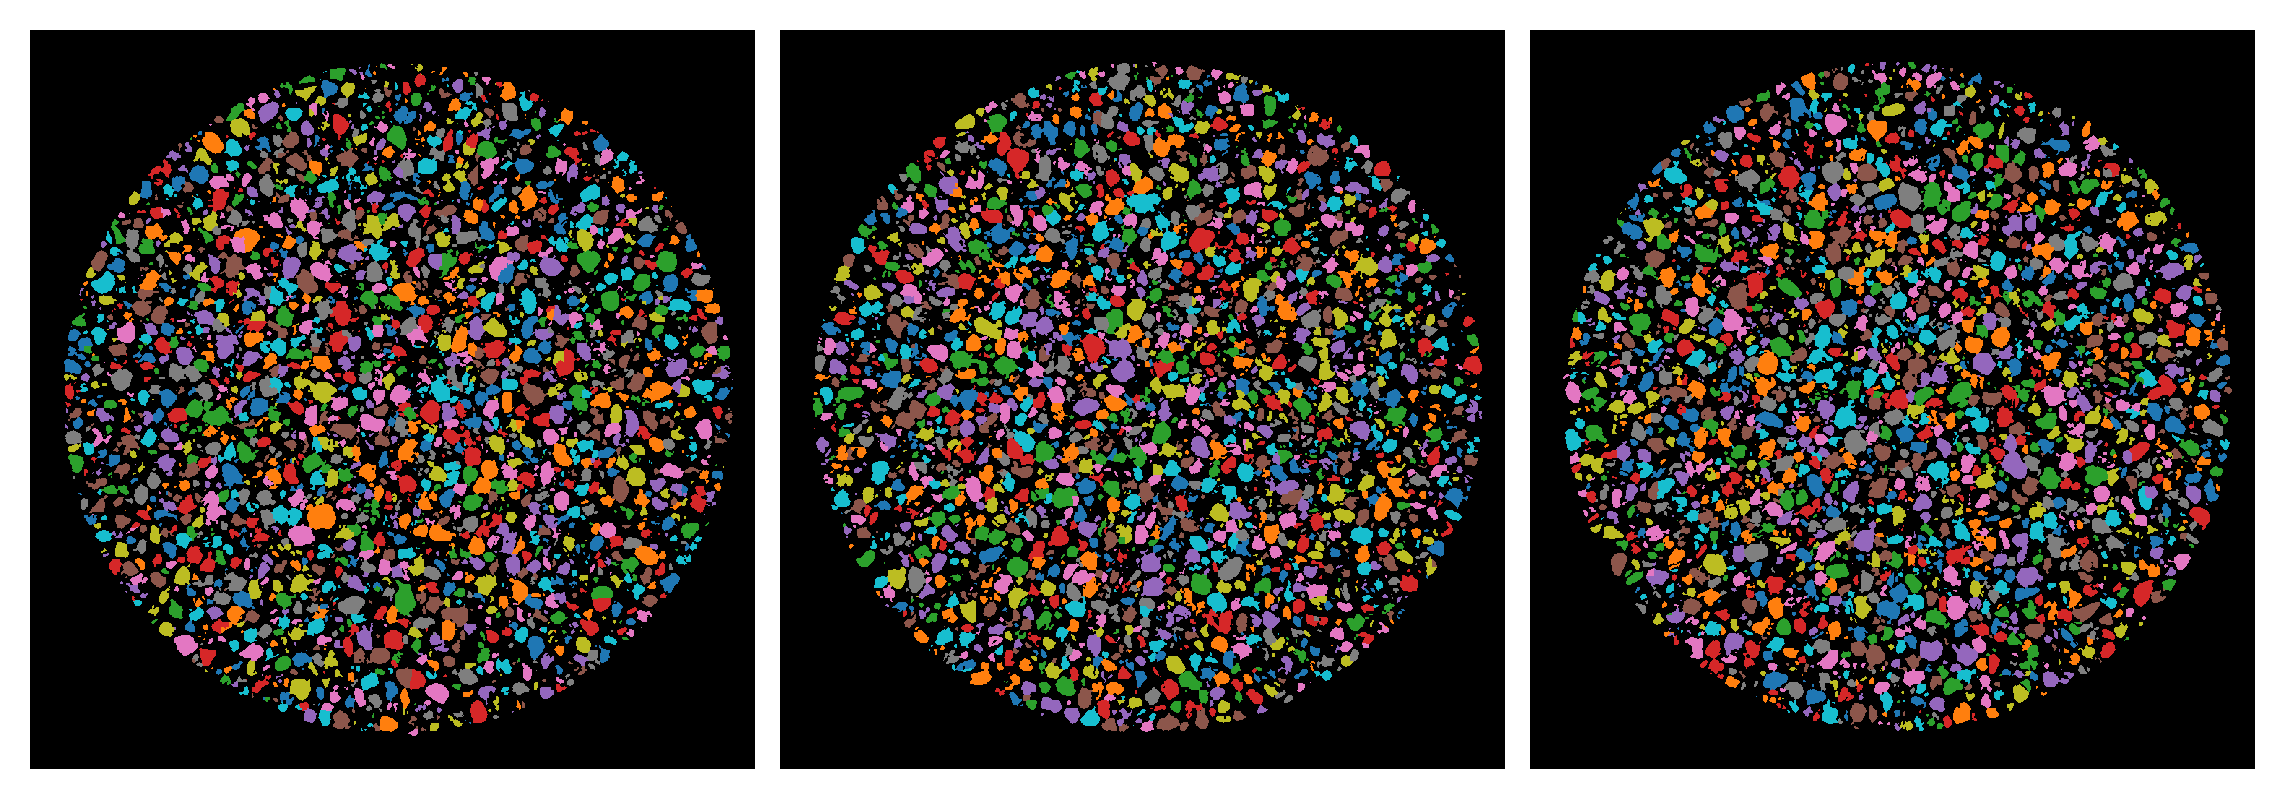

min_peak_distance = 5
Segmenting images...
--> Segmentation complete. 55502 particle(s) segmented.


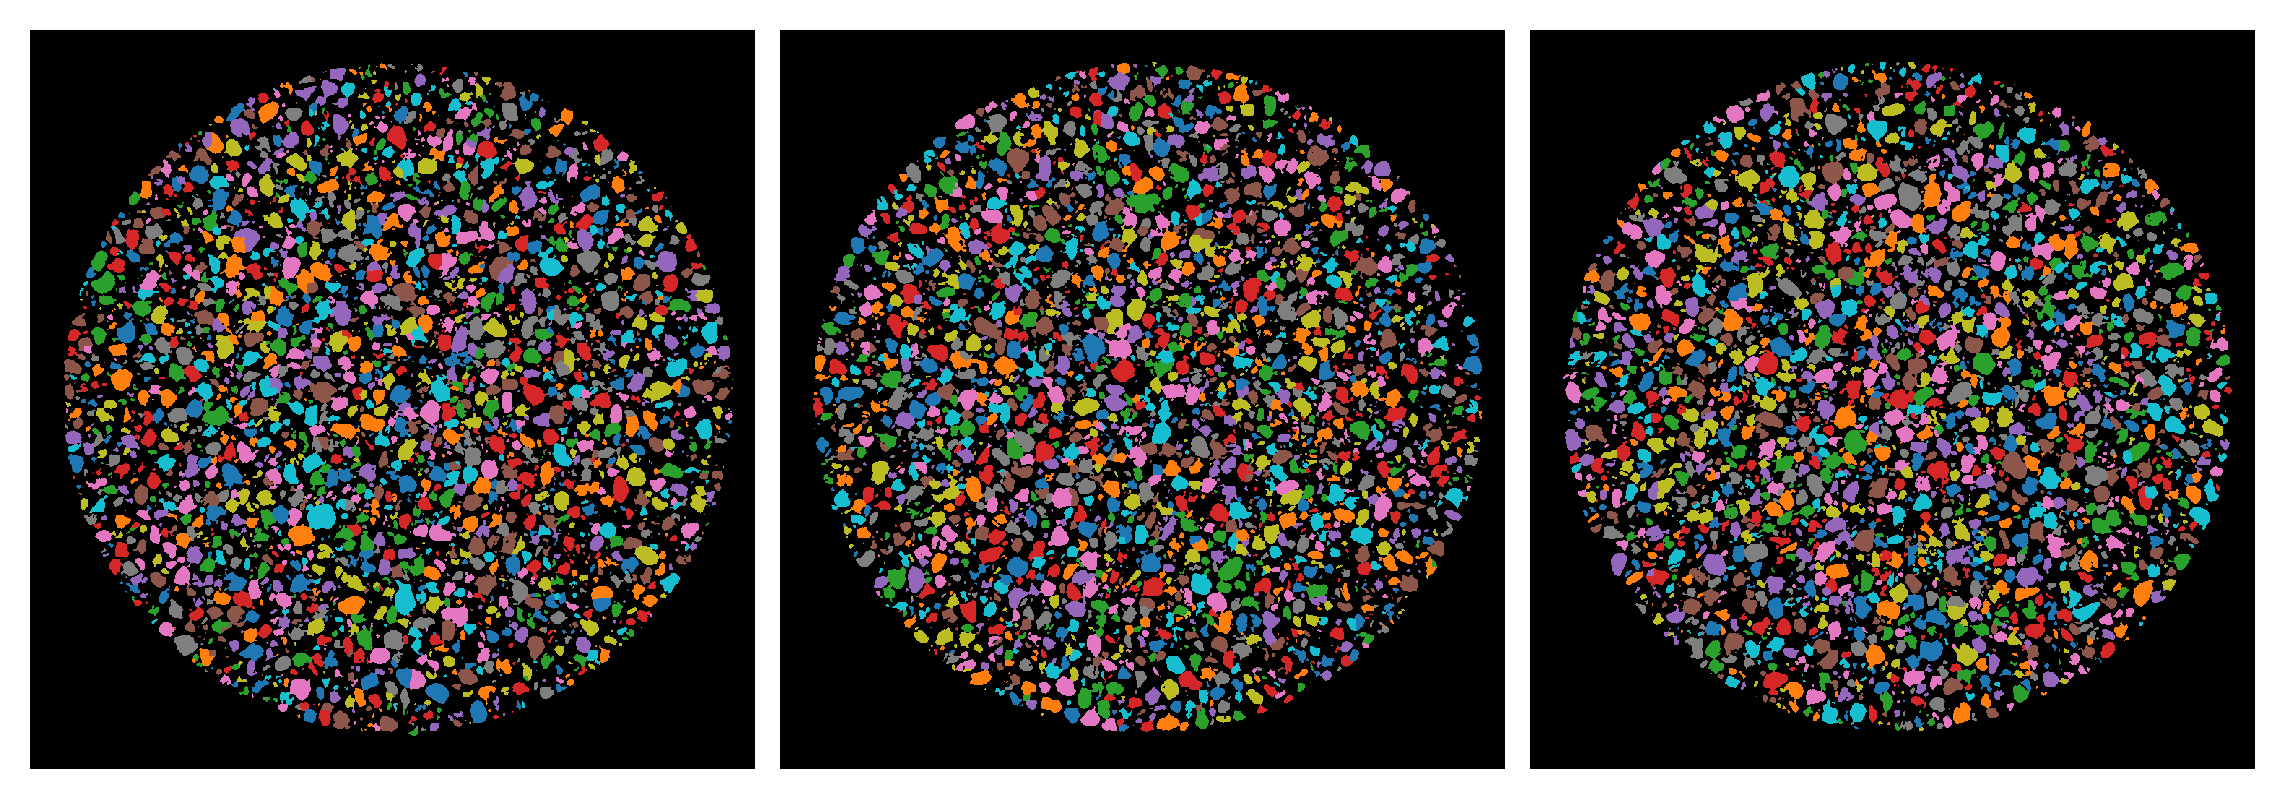

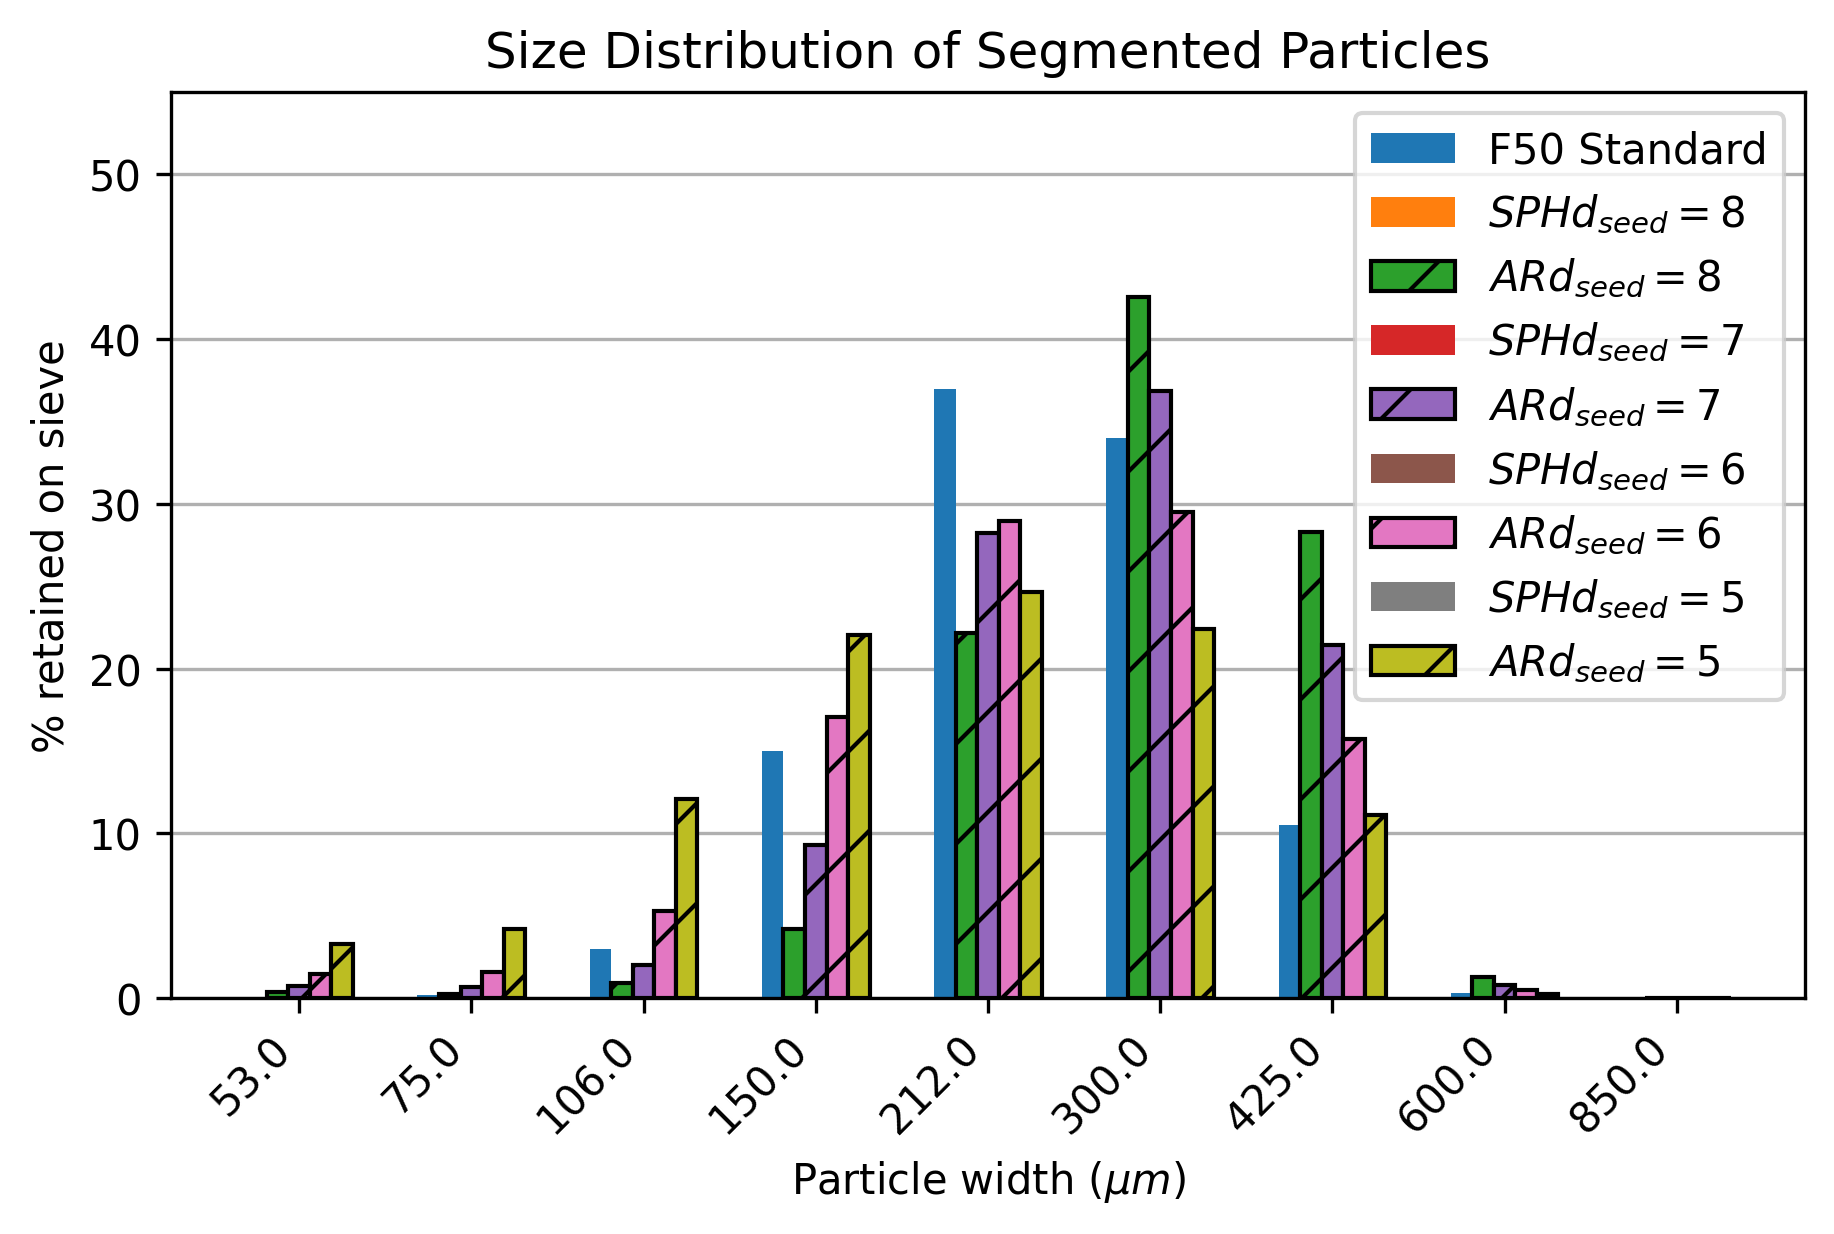

In [13]:
# Collect sieve data
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
diameter_ums = sieve_df.um.to_numpy()
diameter_ums_bins = np.insert(diameter_ums, 0, 0)
r = diameter_ums / 2
ums_vol = 4/3 * np.pi * r**3
ums_vol_bins = np.insert(ums_vol, 0, 0)
f50_pct = sieve_df['pct-retained'].to_numpy()
# Iterate through min_peak_distance values and segment
min_peak_dist_range = np.arange(5, 9)[::-1]
for dist_i in min_peak_dist_range:
    print('min_peak_distance =', dist_i)
    # Segment data
    imgs_labeled = segment.watershed_segment(
        imgs_semantic == 2,
        min_peak_distance=dist_i,
        return_dict=False
    )
    colors = view.get_colors(10, cmap=mpl.cm.tab10)
    labeled_color = [
        color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
        for i in slices
    ]
    fig, axes = view.plot_images(labeled_color, dpi=300)
    # Format segmented data
    labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
    labels_df = labels_df.rename(columns={'area' : 'volume'})
    seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
    seg_sphere_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
    seg_sphere_pct = 100 * seg_sphere_hist / labels_df.shape[0]
    sieve_df[f'seg-{dist_i}-sphere-pct'] = seg_sphere_pct
    labels_df['nslices'] = (
        labels_df['bbox-3'].to_numpy() - labels_df['bbox-0'].to_numpy())
    labels_df['nrows'] = (
        labels_df['bbox-4'].to_numpy() - labels_df['bbox-1'].to_numpy())
    labels_df['ncols'] = (
        labels_df['bbox-5'].to_numpy() - labels_df['bbox-2'].to_numpy())
    labels_df['a'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[0], axis=1)
    labels_df['b'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[1], axis=1)
    labels_df['c'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[2], axis=1)
    b_ums = ums_per_pixel * labels_df['b'].to_numpy()
    seg_aspect_hist, bins = np.histogram(b_ums, bins=diameter_ums_bins)
    seg_aspect_pct = 100 * seg_aspect_hist / labels_df.shape[0]
    sieve_df[f'seg-{dist_i}-aspect-pct'] = seg_aspect_pct
    plt.show()
save_path = Path('../data/F63-slices_280_to_670-particle-sizes.csv')
if not save_path.exists():
    sieve_df.to_csv(save_path)

min_peak_distance = 4
Segmenting images...
--> Segmentation complete. 79211 particle(s) segmented.


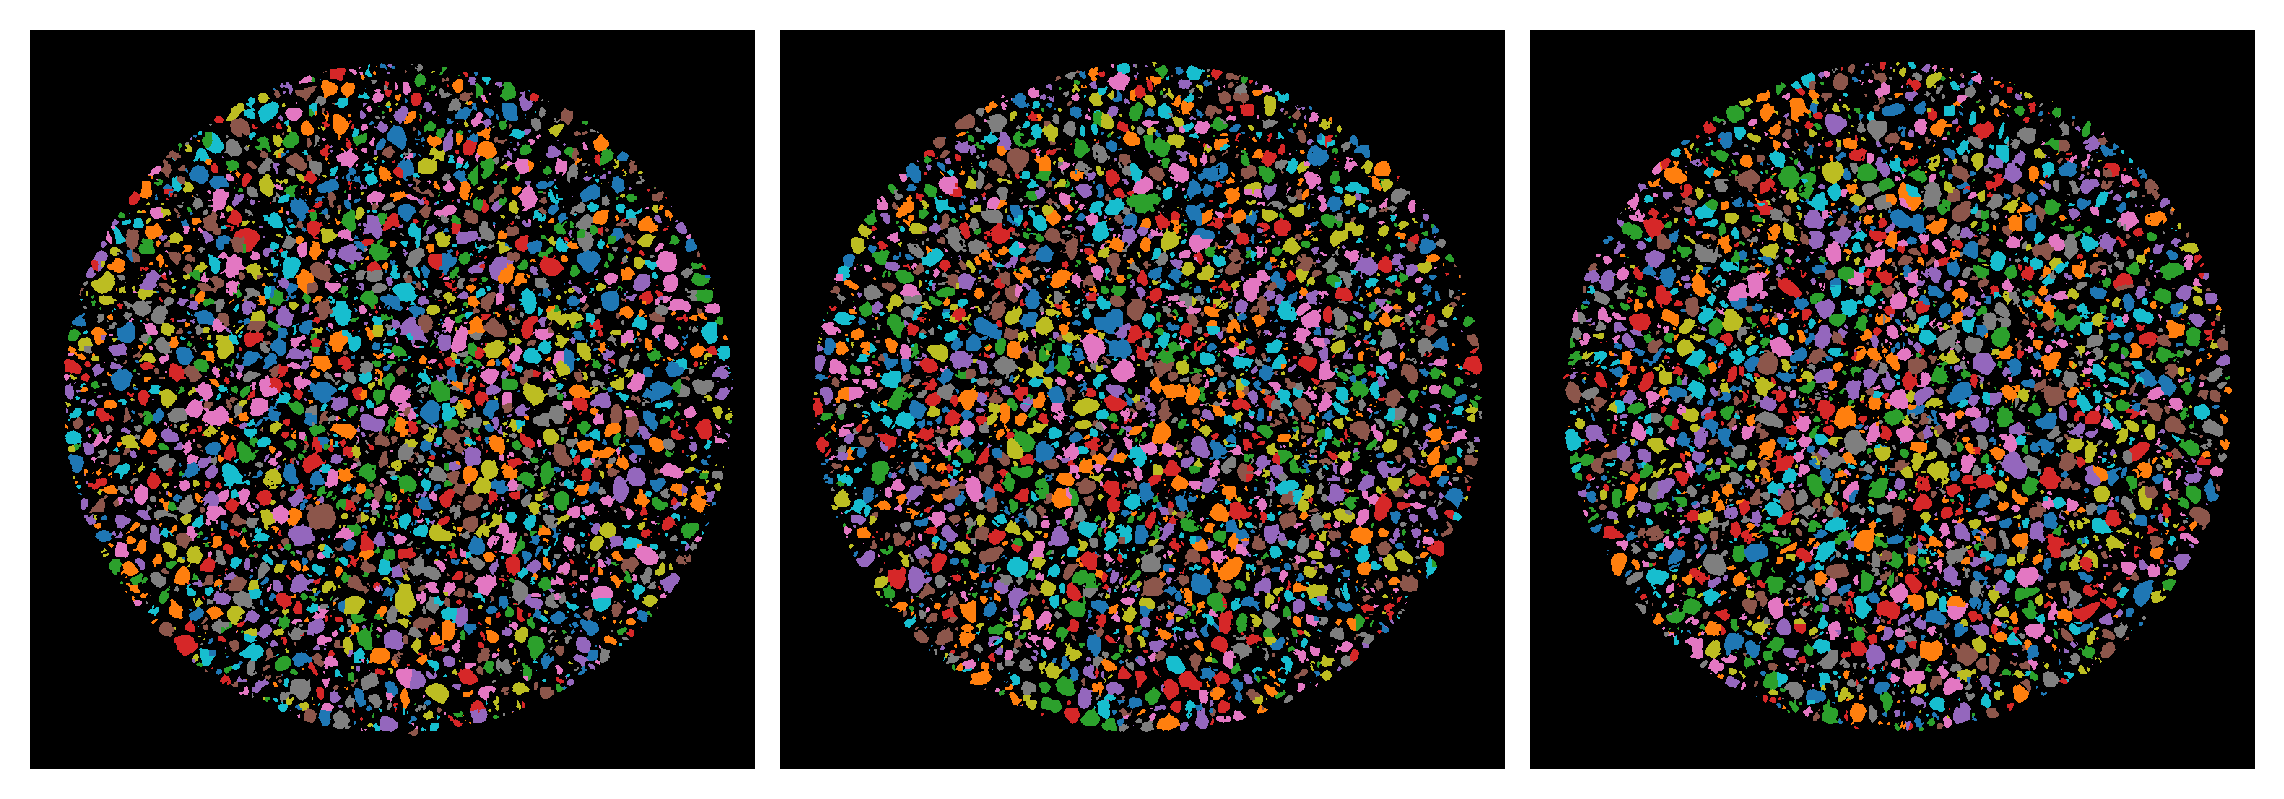

In [38]:
for dist_i in [4]:
    print('min_peak_distance =', dist_i)
    # Segment data
    imgs_labeled = segment.watershed_segment(
        imgs_semantic == 2,
        min_peak_distance=dist_i,
        return_dict=False
    )
    colors = view.get_colors(10, cmap=mpl.cm.tab10)
    labeled_color = [
        color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
        for i in slices
    ]
    fig, axes = view.plot_images(labeled_color, dpi=300)
    # Format segmented data
    labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
    labels_df = labels_df.rename(columns={'area' : 'volume'})
    seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
    seg_sphere_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
    seg_sphere_pct = 100 * seg_sphere_hist / labels_df.shape[0]
    sieve_df[f'seg-{dist_i}-sphere-pct'] = seg_sphere_pct
    labels_df['nslices'] = (
        labels_df['bbox-3'].to_numpy() - labels_df['bbox-0'].to_numpy())
    labels_df['nrows'] = (
        labels_df['bbox-4'].to_numpy() - labels_df['bbox-1'].to_numpy())
    labels_df['ncols'] = (
        labels_df['bbox-5'].to_numpy() - labels_df['bbox-2'].to_numpy())
    labels_df['a'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[0], axis=1)
    labels_df['b'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[1], axis=1)
    labels_df['c'] = labels_df.apply(
        lambda row: row['nslices' : 'ncols'].nlargest(3).iloc[2], axis=1)
    b_ums = ums_per_pixel * labels_df['b'].to_numpy()
    seg_aspect_hist, bins = np.histogram(b_ums, bins=diameter_ums_bins)
    seg_aspect_pct = 100 * seg_aspect_hist / labels_df.shape[0]
    sieve_df[f'seg-{dist_i}-aspect-pct'] = seg_aspect_pct
    plt.show()

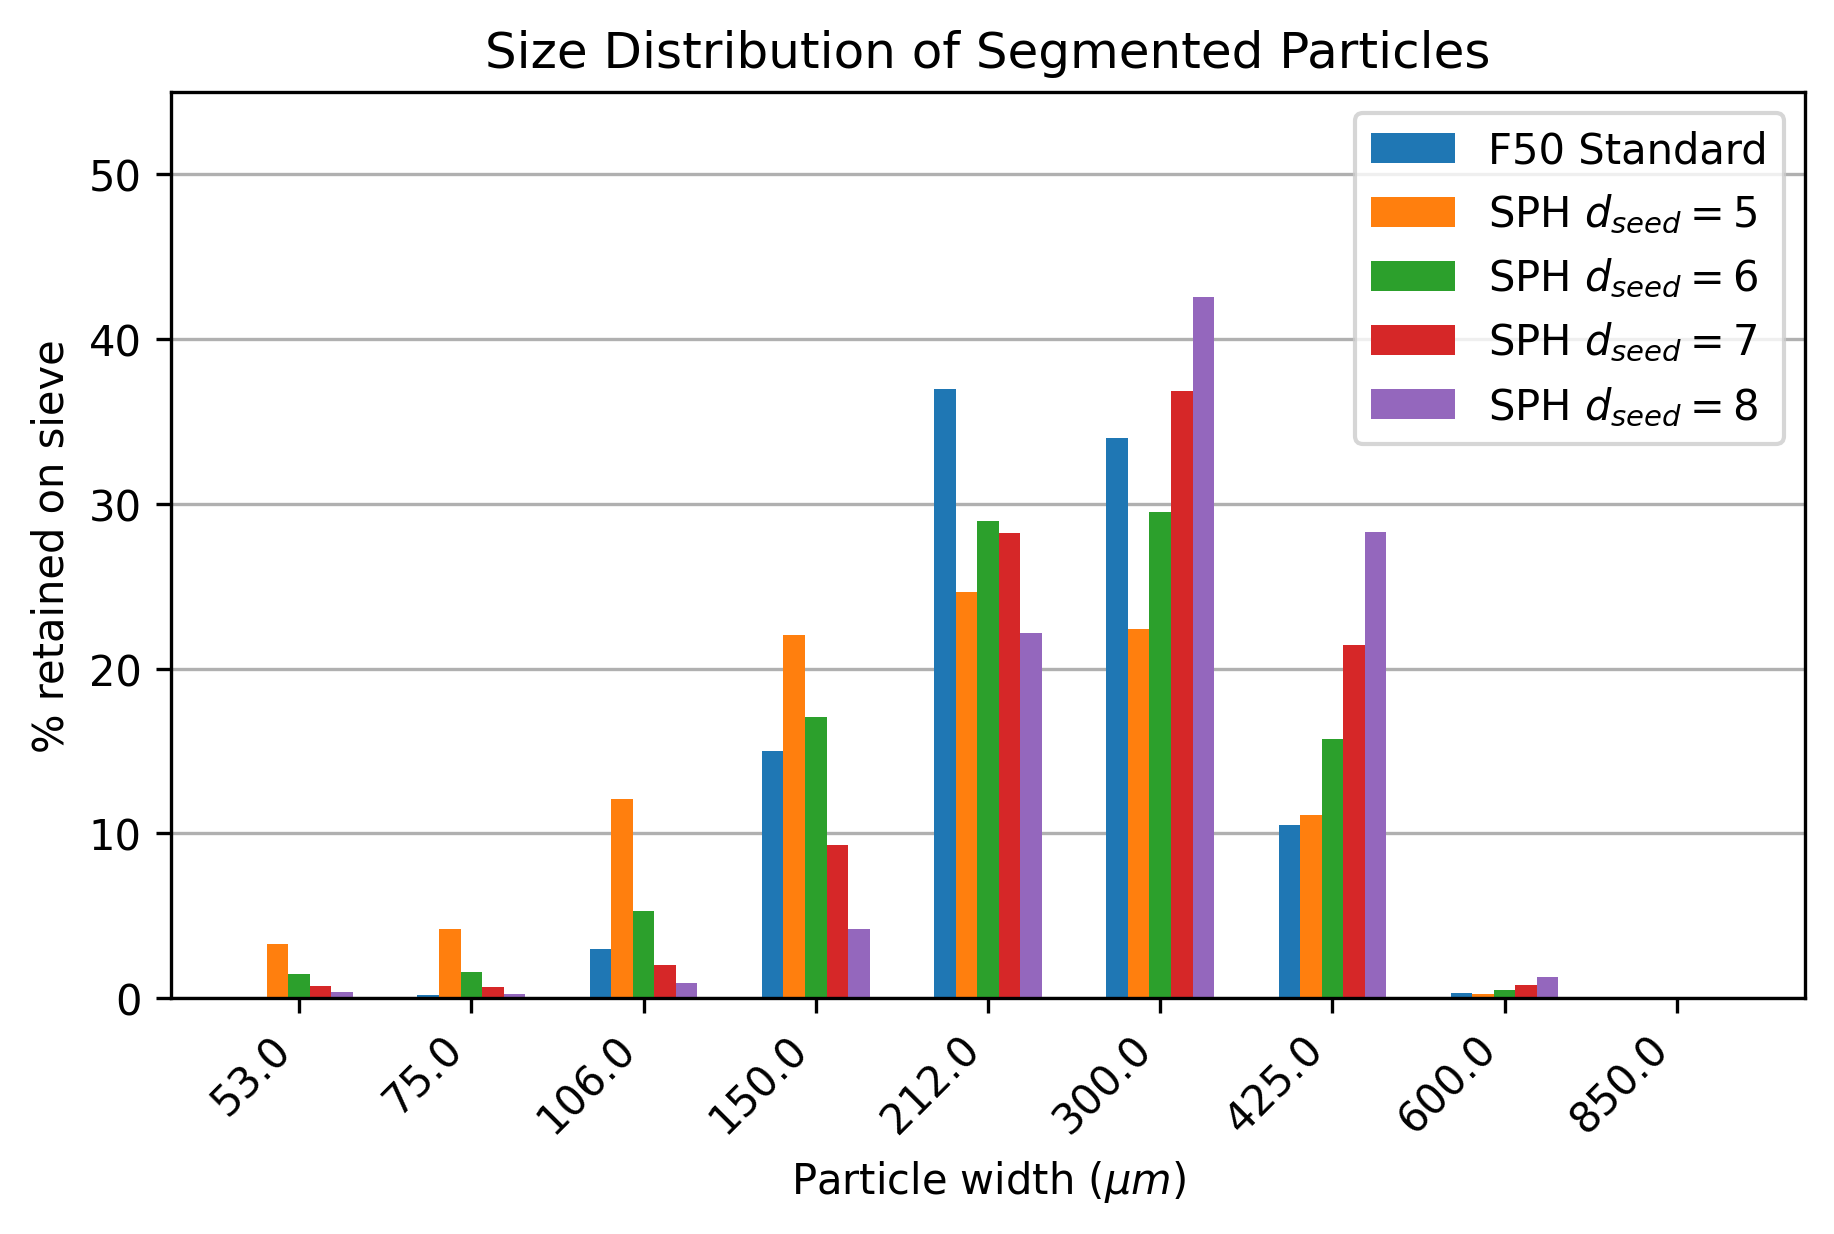

In [55]:
min_peak_dist_range = np.arange(5, 9)
# Plot histogram
fig, ax = plt.subplots(facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / (min_peak_dist_range.shape[0])  # the width of the bars
rects_f50 = ax.bar(
    x_pos - width * min_peak_dist_range.shape[0] / 2,
    np.around(f50_pct, 2), width, zorder=2,
    label='F50 Standard')
for i, dist_i in enumerate(min_peak_dist_range):
    sphere_i_pct = sieve_df[f'seg-{dist_i}-sphere-pct'].to_numpy()
    rects_seg = ax.bar(
        x_pos + (width * (i + 1 - min_peak_dist_range.shape[0] / 2)),
        np.around(sphere_i_pct, 2),
        width, zorder=2, facecolor=f'C{i + 1}',
        label=f'SPH $d_{{seed}}={dist_i}$')
    aspect_i_pct = sieve_df[f'seg-{dist_i}-aspect-pct'].to_numpy()
    # rects_seg = ax.bar(
    #     x_pos + (width * (i + 1 - min_peak_dist_range.shape[0] / 2)),
    #     np.around(aspect_i_pct, 2),
    #     width, zorder=2, facecolor=f'C{i + 1}',
    #     edgecolor='black', hatch="/", label=f'AR $d_{{seed}}={dist_i}$')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Size Distribution of Segmented Particles')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 55])
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(x_pos, diameter_ums, rotation=45, ha='right')
ax.set_xlabel('Particle width ($\mu m$)')
ax.legend()
# ax.bar_label(rects_f50, padding=3, rotation=90)
# ax.bar_label(rects_seg, padding=3, rotation=90)
plt.show()

### Alternative segmentated particle size distributions

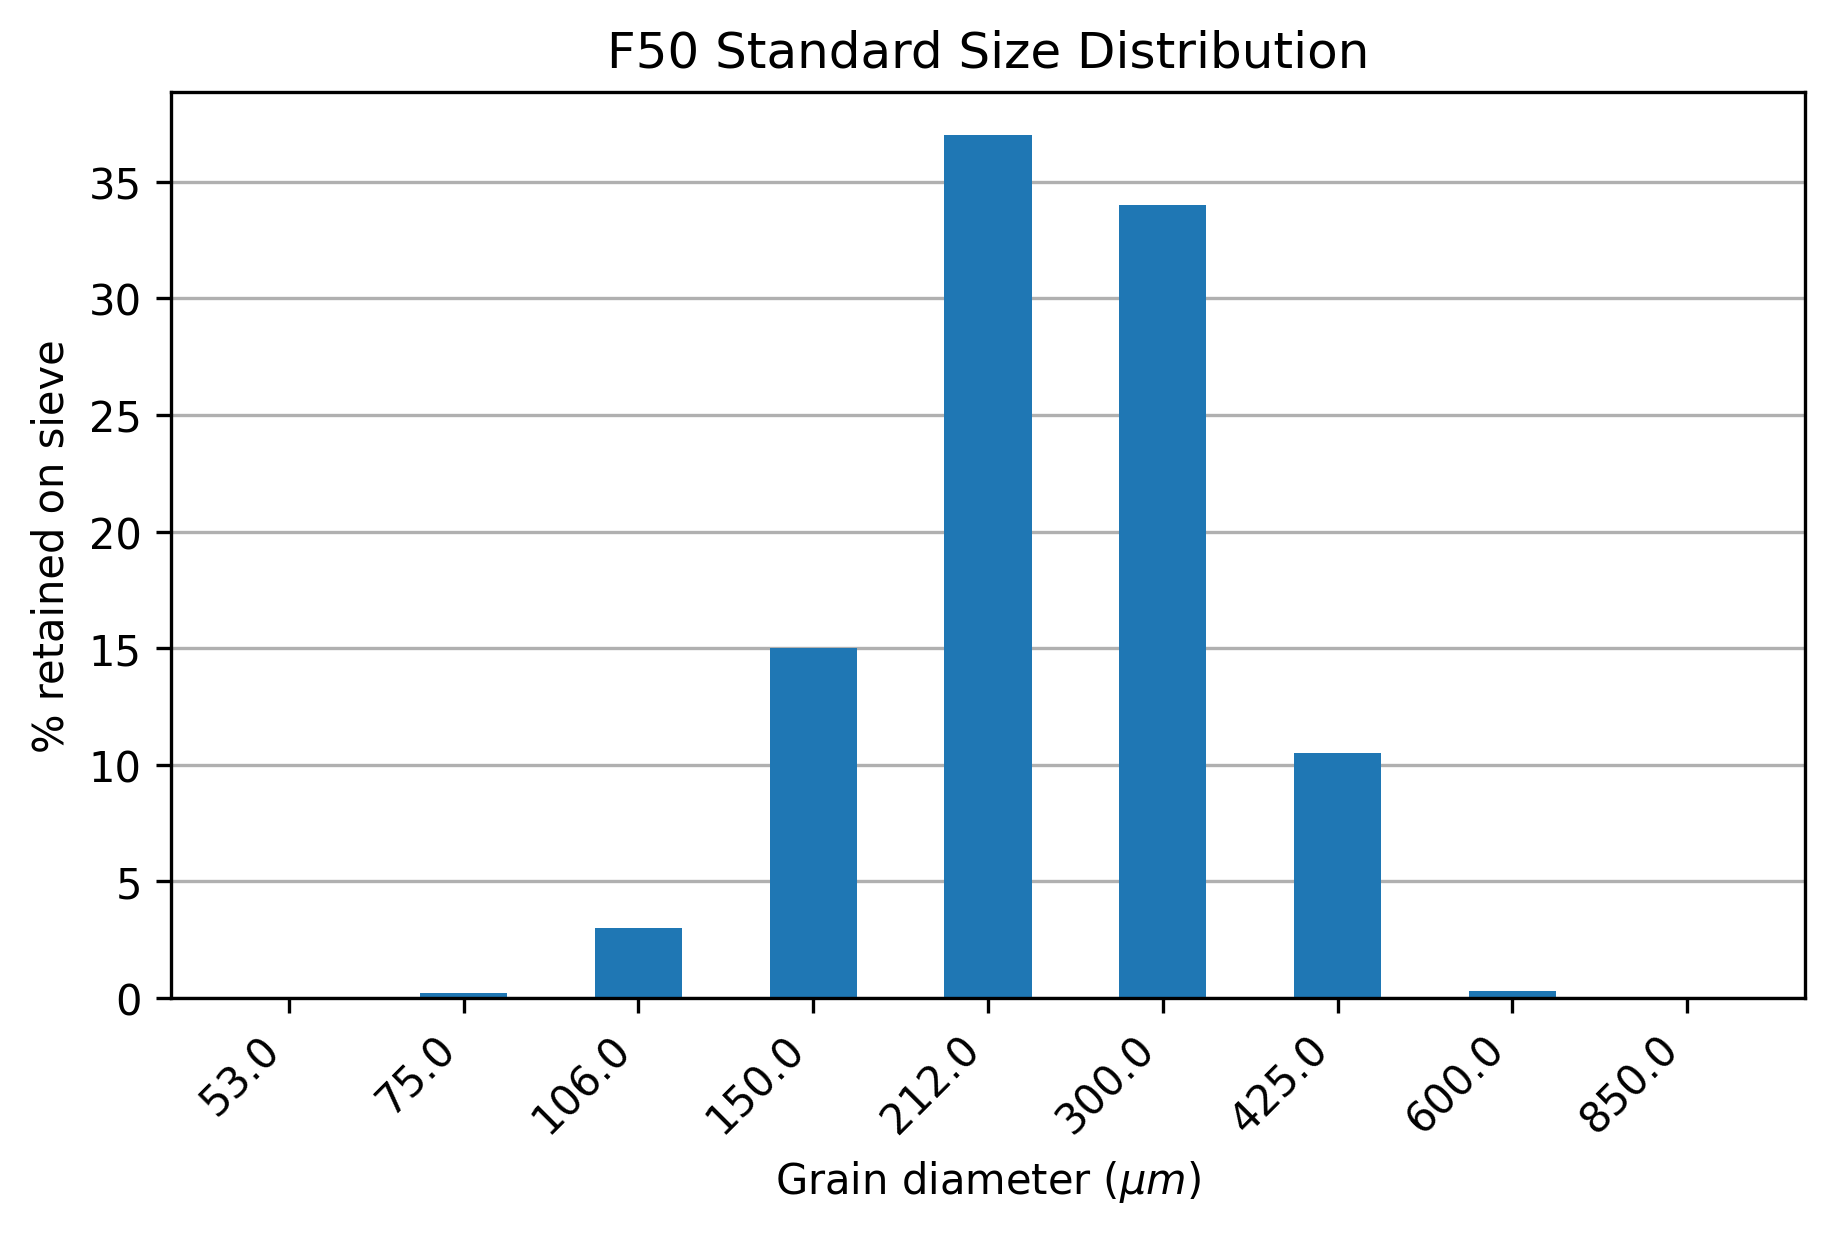

In [14]:
# Plot histogram
fig, ax = plt.subplots(facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5  # the width of the bars
rects_f50 = ax.bar(
    x_pos, np.around(f50_pct, 2), width, zorder=2,
    label='F50 Standard')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('F50 Standard Size Distribution')
ax.set_ylabel(r'% retained on sieve')
# ax.set_ylim([0, 55])
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(x_pos, diameter_ums, rotation=45, ha='right')
ax.set_xlabel('Grain diameter ($\mu m$)')
# ax.bar_label(rects_f50, padding=3, rotation=90)
plt.show()

## Size distribution by equivalent sphere

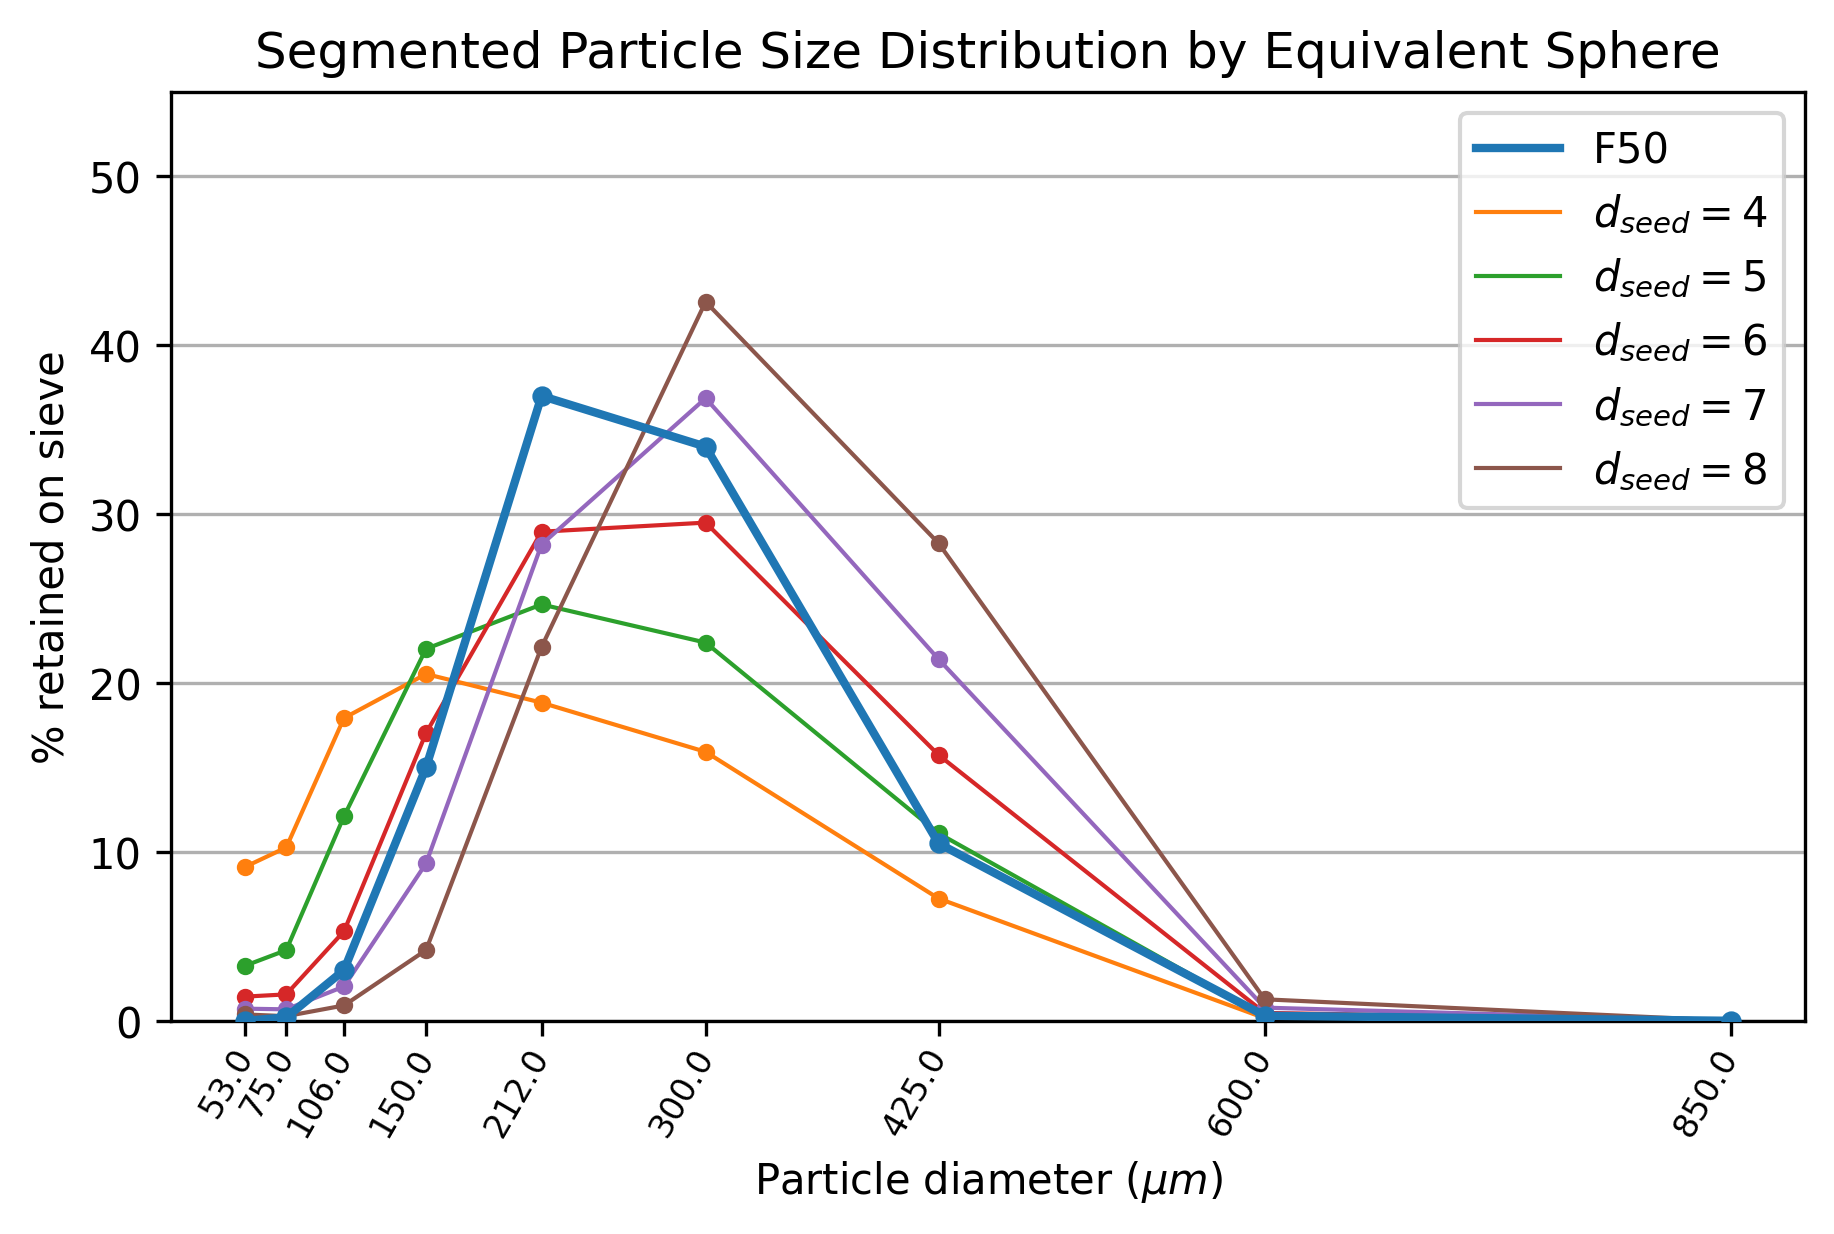

In [50]:
# Plot histogram
fig, ax = plt.subplots(facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
ax.scatter(diameter_ums, f50_pct, s=15, zorder=3)
ax.plot(diameter_ums, f50_pct, linewidth=2, zorder=3, label='F50')
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'seg-{dist_i}-sphere-pct'].to_numpy()
    ax.scatter(
        diameter_ums, seg_i_pct, s=10, zorder=2)
    ax.plot(diameter_ums, seg_i_pct, linewidth=1, zorder=2,
        label=f'$d_{{seed}}={dist_i}$')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Segmented Particle Size Distribution by Equivalent Sphere')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 55])
ax.grid(True, axis='y', zorder=0)
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.set_xticks(diameter_ums)
ax.set_xticklabels(
    diameter_ums, size=8, ha='right', va='center', rotation=60,
    rotation_mode='anchor')
ax.legend()
plt.show()

In [17]:
for i in min_peak_dist_range:
    sieve_df[f'pct-retained-diff-{i}'] = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'seg-{i}-sphere-pct'])
    print(
        f'Diff equiv sphere, min_peak_distance = {i}:',
        round(sieve_df[f'pct-retained-diff-{i}'].sum(), 2))
sieve_df

Diff equiv sphere, min_peak_distance = 8: 55.54
Diff equiv sphere, min_peak_distance = 7: 30.9
Diff equiv sphere, min_peak_distance = 6: 25.08
Diff equiv sphere, min_peak_distance = 5: 47.95


usa     um  pct-retained  seg-8-sphere-pct  seg-8-aspect-pct  \
8  270   53.0           0.0          0.374546          0.295097   
7  200   75.0           0.2          0.272397          0.204298   
6  140  106.0           3.0          0.907990          0.401029   
5  100  150.0          15.0          4.184322          1.562500   
4   70  212.0          37.0         22.136047         10.782385   
3   50  300.0          34.0         42.577179         26.959746   
2   40  425.0          10.5         28.276332         39.906174   
1   30  600.0           0.3          1.271186         18.908898   
0   20  850.0           0.0          0.000000          0.979873   

   seg-7-sphere-pct  seg-7-aspect-pct  seg-6-sphere-pct  seg-6-aspect-pct  \
8          0.716868          0.539183          1.431282          1.039841   
7          0.677042          0.499357          1.563363          1.222353   
6          2.031126          0.995650          5.302466          2.507144   
5          9.316218          3.532259         17.036094          8.232271   
4         28.202929         17.593897         28.961840         23.973968   
3         36.866614         29.455916         29.499772         27.801926   
2         21.411065         34.529134         15.739295         27.345645   
1          0.778139         12.465535          0.465887          7.739968   
0          0.000000          0.389069          0.000000          0.136884   

   seg-5-sphere-pct  seg-5-aspect-pct  pct-retained-diff-8  \
8          3.262945          2.308025             0.374546   
7          4.181831          3.291773             0.072397   
6         12.109474          6.327700             2.092010   
5         22.024432         14.469749            10.815678   
4         24.654967         25.972037            14.863953   
3         22.395589         22.903679             8.577179   
2         11.098699         20.150625            17.776332   
1          0.272062          4.536773             0.971186   
0          0.000000          0.039638             0.000000   

   pct-retained-diff-7  pct-retained-diff-6  pct-retained-diff-5  
8             0.716868             1.431282             3.262945  
7             0.477042             1.363363             3.981831  
6             0.968874             2.302466             9.109474  
5             5.683782             2.036094             7.024432  
4             8.797071             8.038160            12.345033  
3             2.866614             4.500228            11.604411  
2            10.911065             5.239295             0.598699  
1             0.478139             0.165887             0.027938  
0             0.000000             0.000000             0.000000

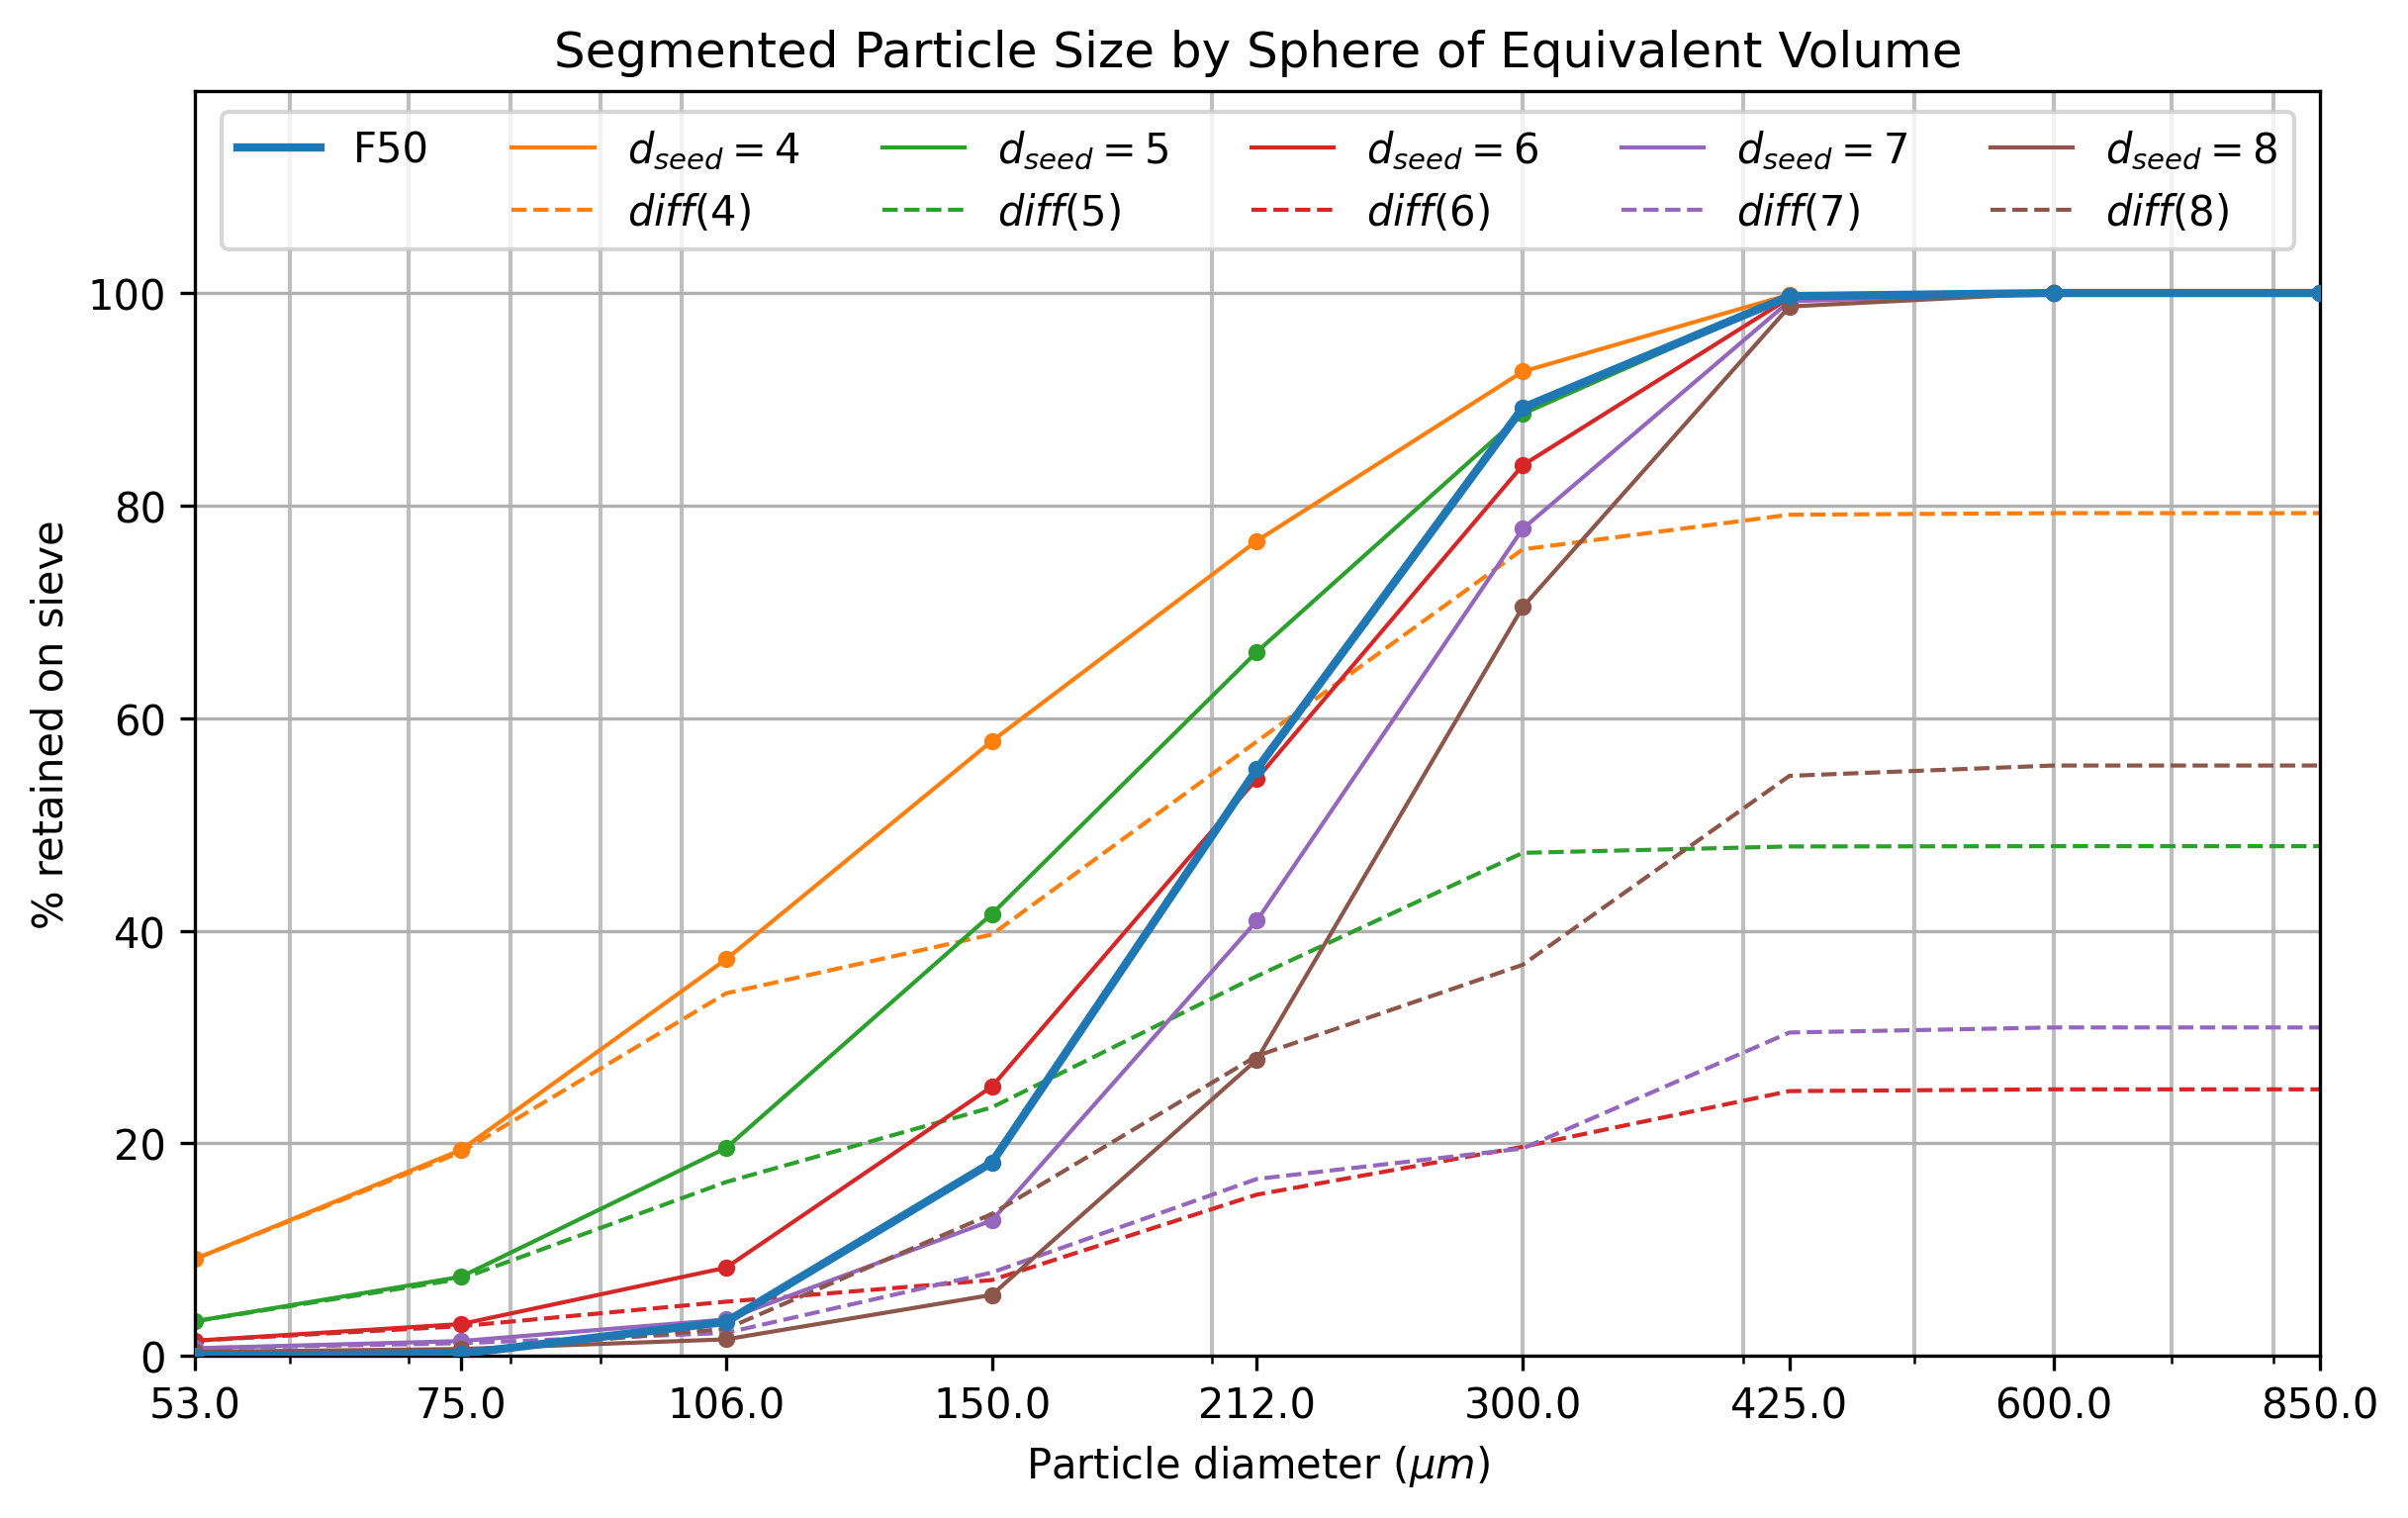

In [57]:
min_peak_dist_range = np.arange(4, 9)
# Plot histogram
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
ax.scatter(diameter_ums, np.cumsum(f50_pct), s=10, zorder=3)
ax.plot(
    diameter_ums, np.cumsum(f50_pct), linewidth=2, zorder=3,
    label='F50')
# Invsibile dummy plot to offset labels in legend
ax.plot(np.zeros(0), np.zeros(0), 'w', alpha=0, label=' ')
# Plot segmented particle size distributions
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'seg-{dist_i}-sphere-pct'].to_numpy()
    seg_i_pct_cum = np.cumsum(seg_i_pct)
    ax.scatter(
        diameter_ums, np.cumsum(seg_i_pct), s=10, zorder=2)
        # label=f'Segmented,\nseparation = {dist_i}')
    ax.plot(diameter_ums, np.cumsum(seg_i_pct), linewidth=1, zorder=2,
        label=f'$d_{{seed}}={dist_i}$')
    # Plot difference between standard and segmented distributions
    seg_i_diff = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'seg-{dist_i}-sphere-pct'])
    ax.plot(
        diameter_ums, np.cumsum(seg_i_diff), '--', linewidth=1, zorder=2,
        c=f'C{i + 1}', label=f'$diff({dist_i})$')
ax.set_title(
    'Segmented Particle Size by Sphere of Equivalent Volume')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 119])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.set_xscale('log')
ax.grid(True, axis='y', zorder=0)
ax.set_xlim([53, 850])
for v in np.concatenate(
    (np.arange(60, 100, 10, dtype=int), np.arange(100, 900, 100, dtype=int))):
    ax.axvline(v, linewidth=1, c='k', alpha=0.25, zorder=0)
ax.set_xticks(diameter_ums)
ax.set_xticklabels(diameter_ums)
ax.legend(loc='upper center', ncol=1 + min_peak_dist_range.shape[0])
plt.show()

## Size distribution by aspect ratio

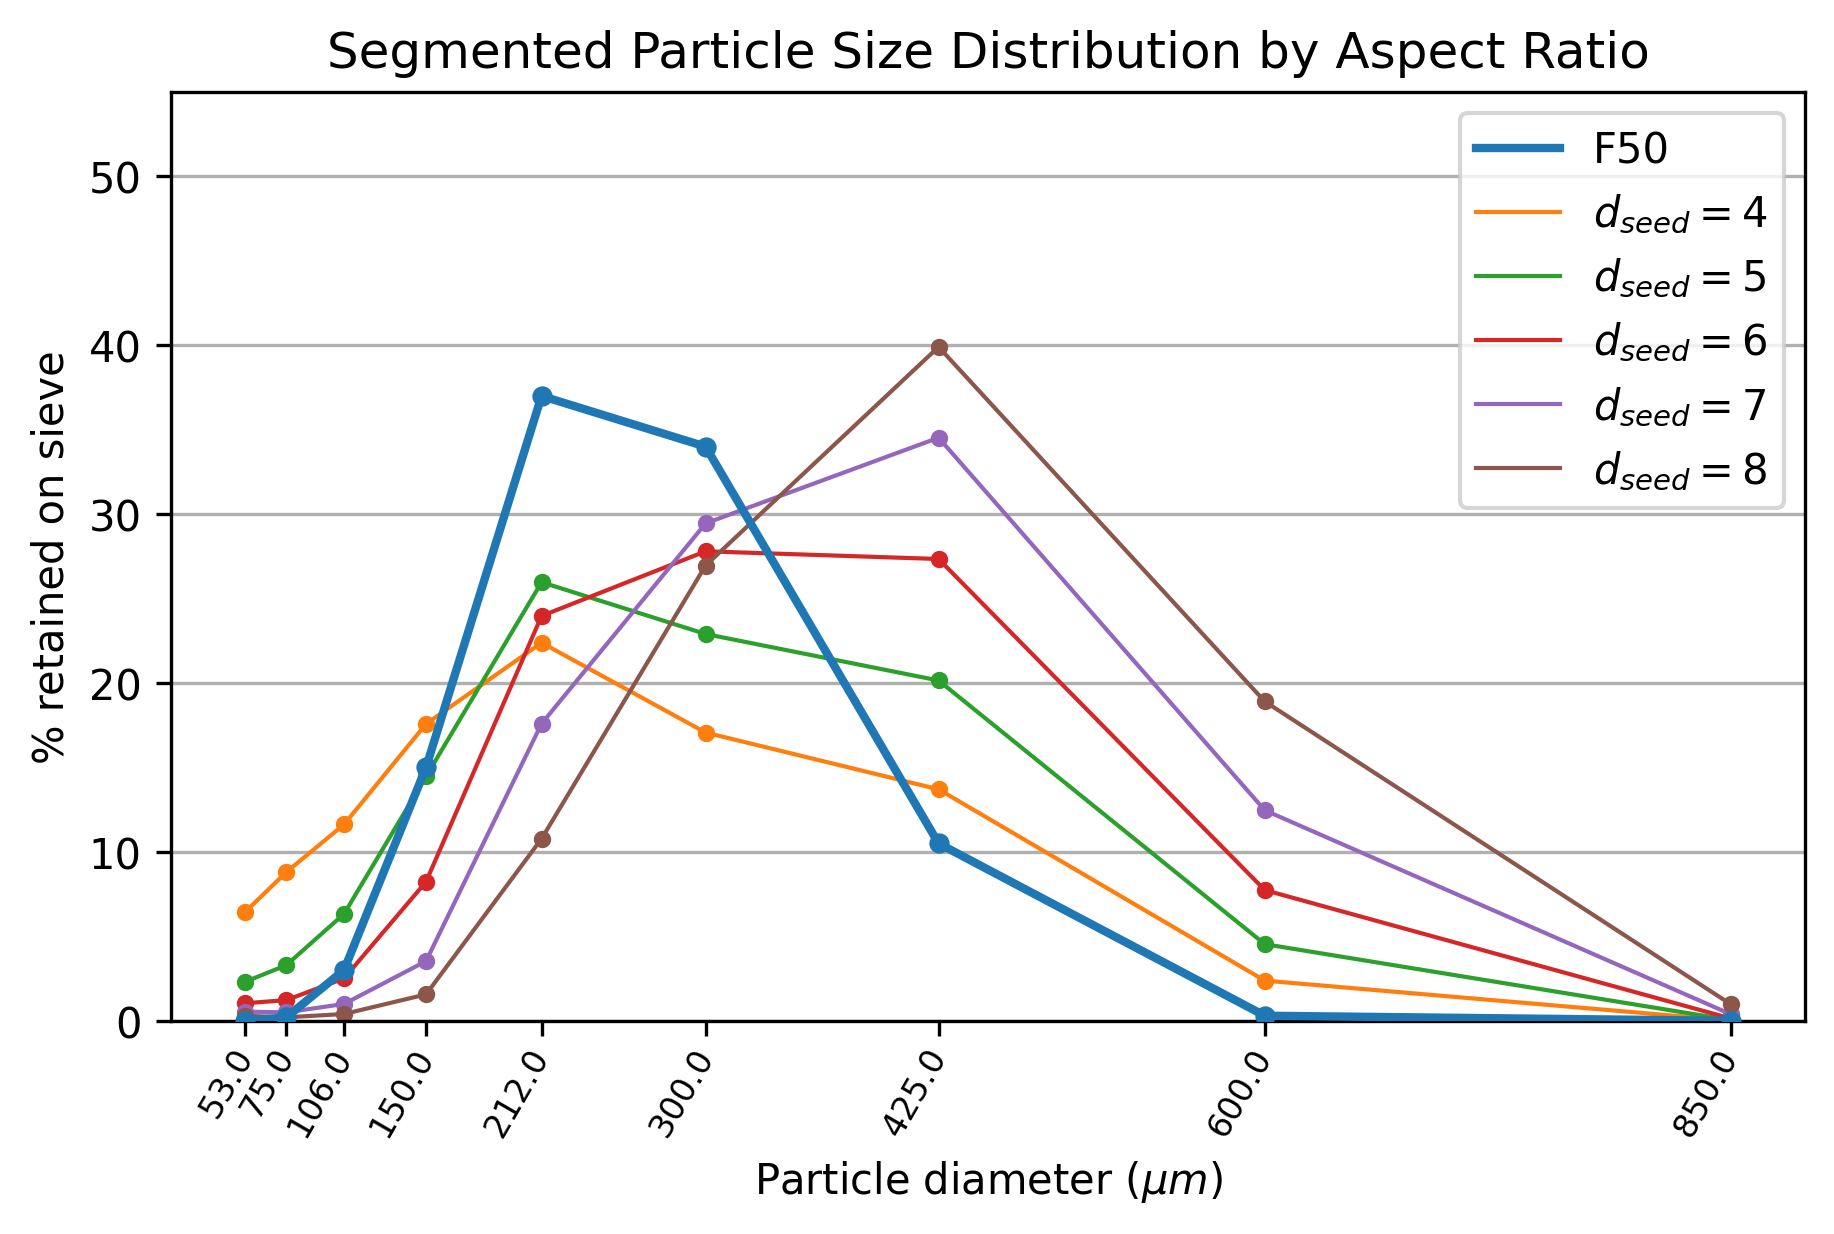

In [44]:
# Plot histogram
fig, ax = plt.subplots(facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
ax.scatter(diameter_ums, f50_pct, s=15, zorder=3)
ax.plot(diameter_ums, f50_pct, linewidth=2, zorder=3, label='F50')
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'seg-{dist_i}-aspect-pct'].to_numpy()
    ax.scatter( diameter_ums, seg_i_pct, s=10, zorder=2)
    ax.plot(diameter_ums, seg_i_pct, linewidth=1, zorder=2,
        label=f'$d_{{seed}}={dist_i}$')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Segmented Particle Size Distribution by Aspect Ratio')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 55])
ax.grid(True, axis='y', zorder=0)
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.set_xticks(diameter_ums)
ax.set_xticklabels(
    diameter_ums, size=8, ha='right', va='center', rotation=60,
    rotation_mode='anchor')
ax.legend()
plt.show()

In [20]:
for i in min_peak_dist_range:
    sieve_df[f'pct-retained-diff-{i}'] = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'seg-{i}-sphere-pct'])
    print(
        f'Diff equiv sphere, min_peak_distance = {i}:',
        round(sieve_df[f'pct-retained-diff-{i}'].sum(), 2))
sieve_df

Diff equiv sphere, min_peak_distance = 8: 55.54
Diff equiv sphere, min_peak_distance = 7: 30.9
Diff equiv sphere, min_peak_distance = 6: 25.08
Diff equiv sphere, min_peak_distance = 5: 47.95


usa     um  pct-retained  seg-8-sphere-pct  seg-8-aspect-pct  \
8  270   53.0           0.0          0.374546          0.295097   
7  200   75.0           0.2          0.272397          0.204298   
6  140  106.0           3.0          0.907990          0.401029   
5  100  150.0          15.0          4.184322          1.562500   
4   70  212.0          37.0         22.136047         10.782385   
3   50  300.0          34.0         42.577179         26.959746   
2   40  425.0          10.5         28.276332         39.906174   
1   30  600.0           0.3          1.271186         18.908898   
0   20  850.0           0.0          0.000000          0.979873   

   seg-7-sphere-pct  seg-7-aspect-pct  seg-6-sphere-pct  seg-6-aspect-pct  \
8          0.716868          0.539183          1.431282          1.039841   
7          0.677042          0.499357          1.563363          1.222353   
6          2.031126          0.995650          5.302466          2.507144   
5          9.316218          3.532259         17.036094          8.232271   
4         28.202929         17.593897         28.961840         23.973968   
3         36.866614         29.455916         29.499772         27.801926   
2         21.411065         34.529134         15.739295         27.345645   
1          0.778139         12.465535          0.465887          7.739968   
0          0.000000          0.389069          0.000000          0.136884   

   seg-5-sphere-pct  seg-5-aspect-pct  pct-retained-diff-8  \
8          3.262945          2.308025             0.374546   
7          4.181831          3.291773             0.072397   
6         12.109474          6.327700             2.092010   
5         22.024432         14.469749            10.815678   
4         24.654967         25.972037            14.863953   
3         22.395589         22.903679             8.577179   
2         11.098699         20.150625            17.776332   
1          0.272062          4.536773             0.971186   
0          0.000000          0.039638             0.000000   

   pct-retained-diff-7  pct-retained-diff-6  pct-retained-diff-5  
8             0.716868             1.431282             3.262945  
7             0.477042             1.363363             3.981831  
6             0.968874             2.302466             9.109474  
5             5.683782             2.036094             7.024432  
4             8.797071             8.038160            12.345033  
3             2.866614             4.500228            11.604411  
2            10.911065             5.239295             0.598699  
1             0.478139             0.165887             0.027938  
0             0.000000             0.000000             0.000000

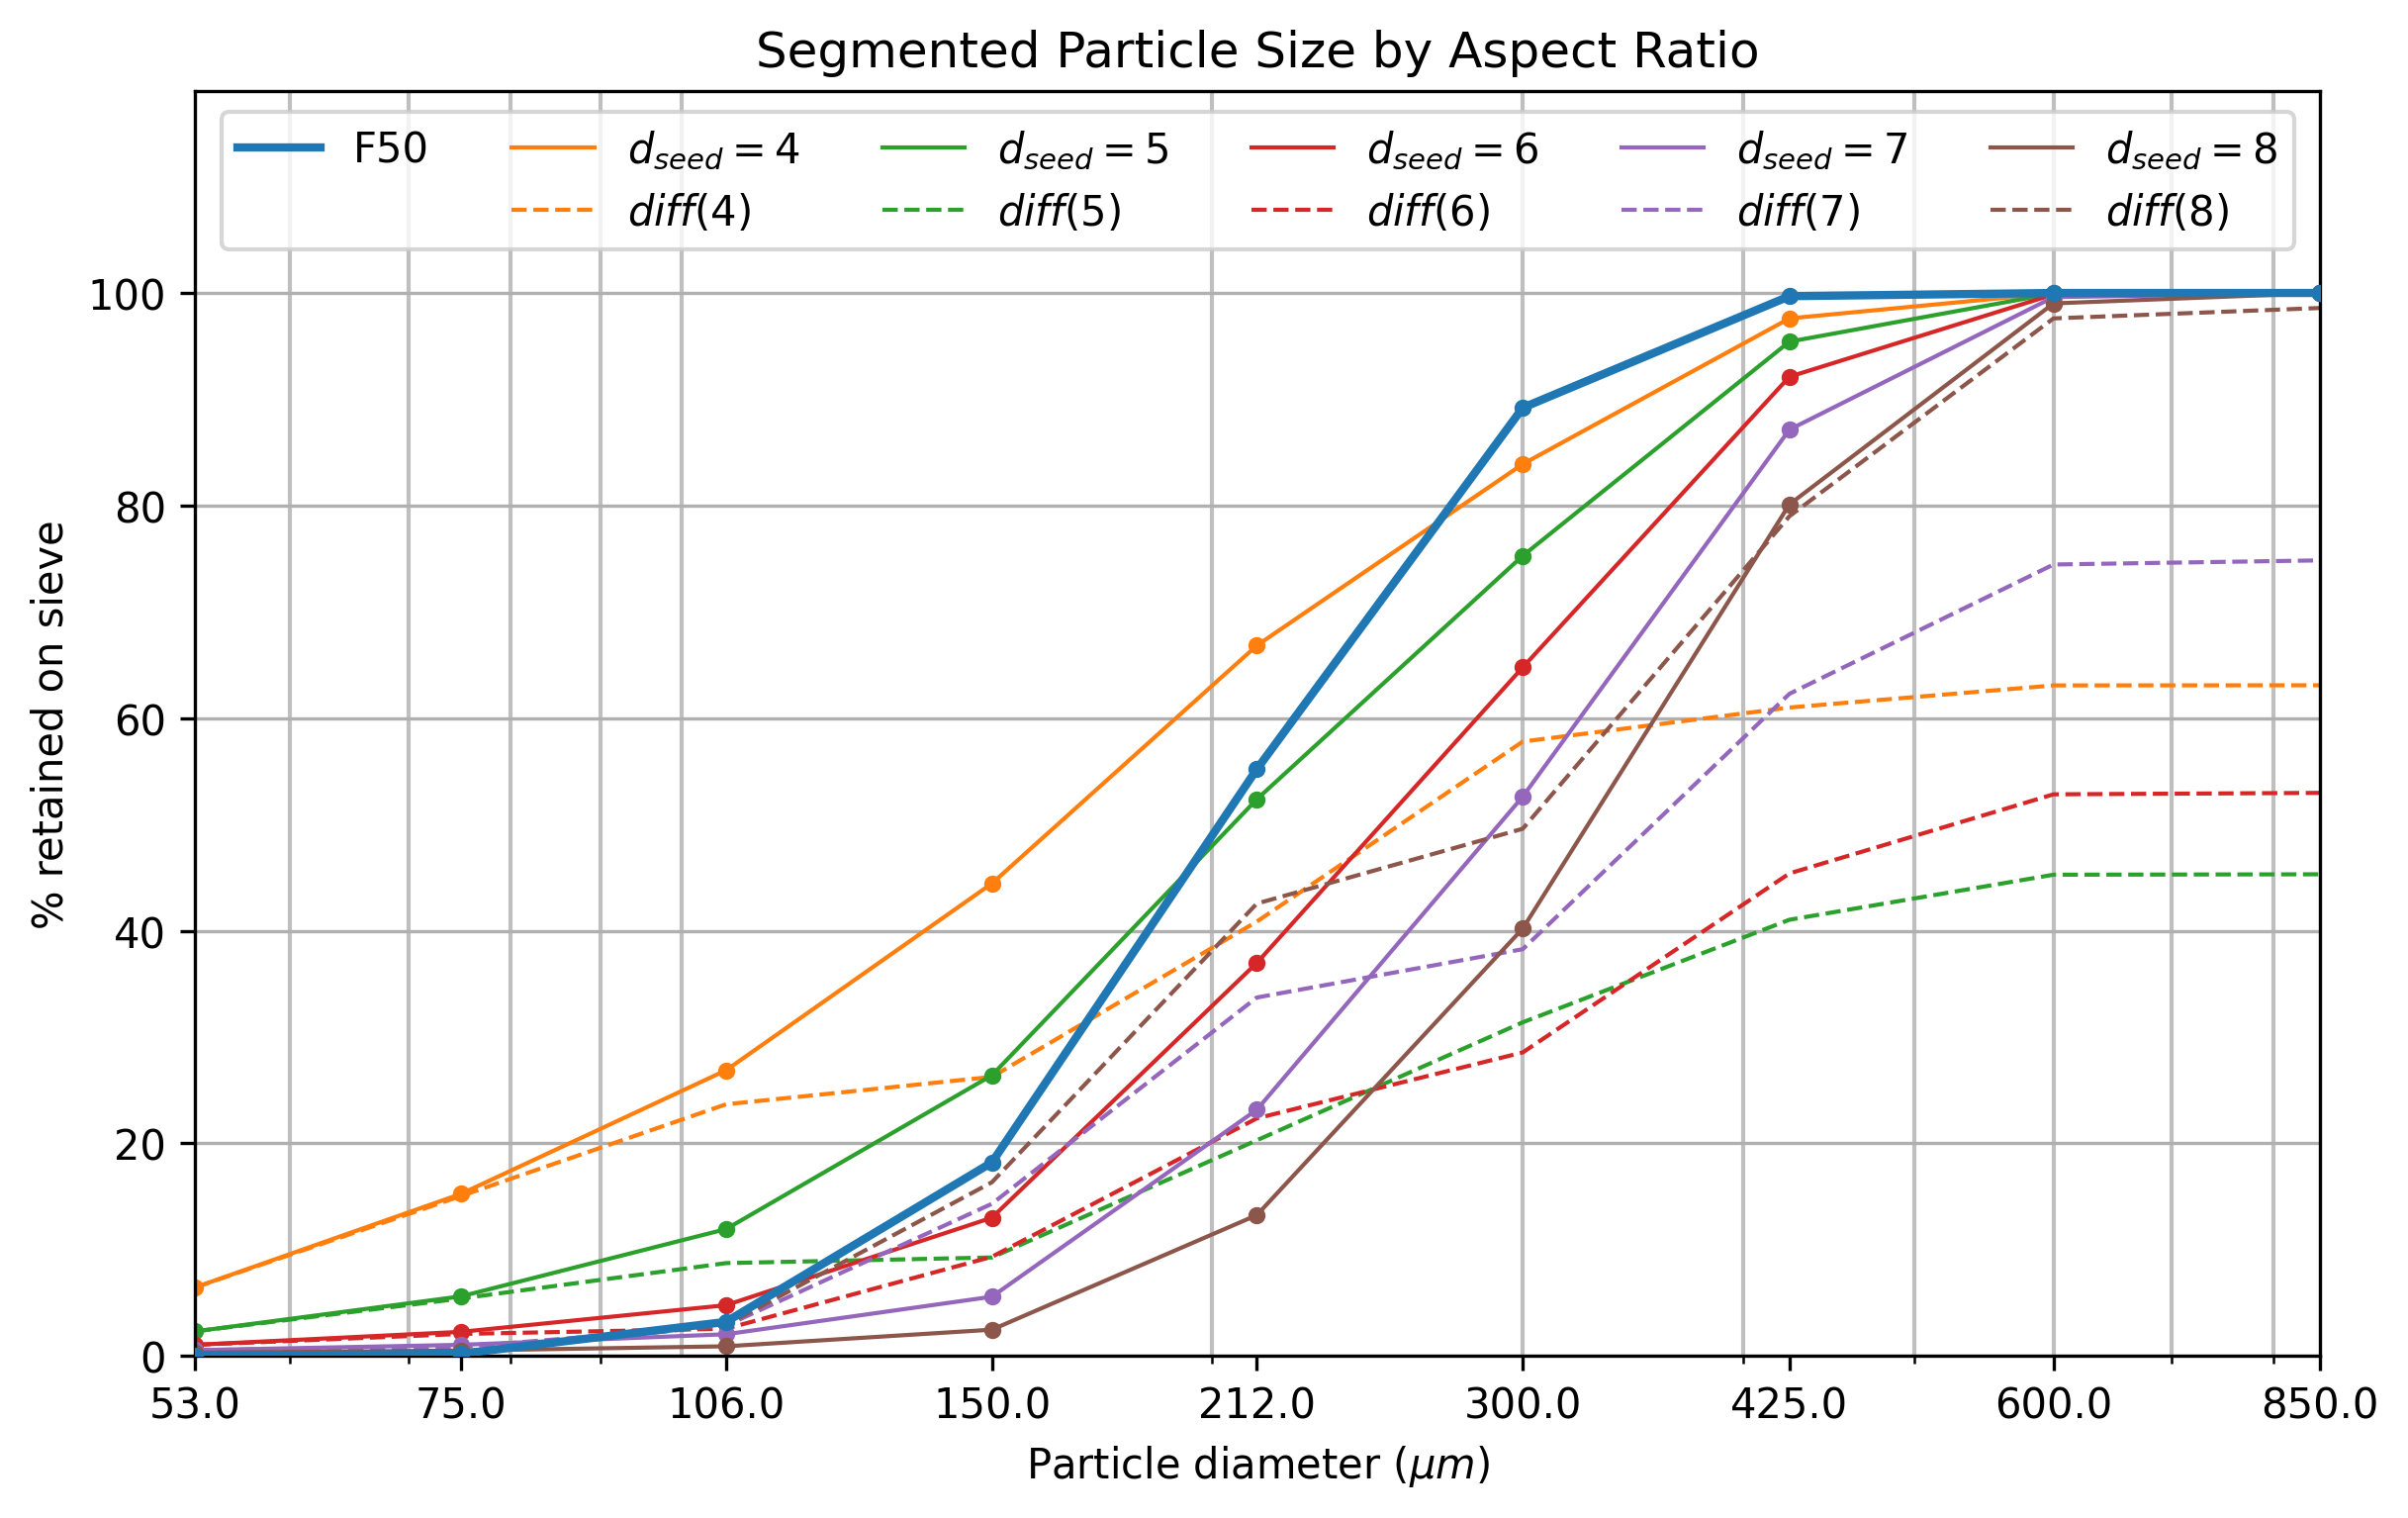

In [58]:
# Plot histogram
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
ax.scatter(diameter_ums, np.cumsum(f50_pct), s=10, zorder=3)
ax.plot(
    diameter_ums, np.cumsum(f50_pct), linewidth=2, zorder=3,
    label='F50')
# Invsibile dummy plot to offset labels in legend
ax.plot(np.zeros(0), np.zeros(0), 'w', alpha=0, label=' ')
# Plot segmented particle size distributions
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'seg-{dist_i}-aspect-pct'].to_numpy()
    seg_i_pct_cum = np.cumsum(seg_i_pct)
    ax.scatter(
        diameter_ums, np.cumsum(seg_i_pct), s=10, zorder=2)
        # label=f'Segmented,\nseparation = {dist_i}')
    ax.plot(diameter_ums, np.cumsum(seg_i_pct), linewidth=1, zorder=2,
        label=f'$d_{{seed}}={dist_i}$')
    # Plot difference between standard and segmented distributions
    seg_i_diff = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'seg-{dist_i}-aspect-pct'])
    ax.plot(
        diameter_ums, np.cumsum(seg_i_diff), '--', linewidth=1, zorder=2,
        c=f'C{i + 1}', label=f'$diff({dist_i})$')
ax.set_title('Segmented Particle Size by Aspect Ratio')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 119])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.set_xscale('log')
ax.grid(True, axis='y', zorder=0)
ax.set_xlim([53, 850])
for v in np.concatenate(
    (np.arange(60, 100, 10, dtype=int), np.arange(100, 900, 100, dtype=int))):
    ax.axvline(v, linewidth=1, c='k', alpha=0.25, zorder=0)
ax.set_xticks(diameter_ums)
ax.set_xticklabels(diameter_ums)
ax.legend(loc='upper center', ncol=1 + min_peak_dist_range.shape[0])
plt.show()